<div style="text-align: center;">
  <img src="https://bse.eu/sites/default/files/bse_logo_small.png" alt="bse_logo_textminingcourse">
</div>

<h1 style="text-align: center;">Supervised Learning to Classify Political Parties Ideological Positions</h1>
<h3 style="text-align: center; font-weight: bold;">Hannes Schiemann | Simon Vellin | Ferran Boada</h3>

# 0) Data Extraction & Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import time as time

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from lightgbm import LGBMRegressor, LGBMClassifier

from time import time

import re
import string
from tabulate import tabulate
from wordcloud import WordCloud
import gensim
from gensim import corpora, models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
import pyLDAvis.gensim_models as gensimvis

# 1) Load Data

In [ ]:
manifestos = pd.read_csv('/Extracted CSV for Notebook/manifestos.csv')
metadata = pd.read_csv('/Extracted CSV for Notebook/1999-2019_CHES_dataset_means(v3).csv')

## a. Preparing "manifestos"

### (i) Create 'election year' column

In [15]:
# Extract the year using a regex pattern that looks for four digits
manifestos['election_year'] = manifestos['date'].str.extract(r'(\d{4})', expand=False)
manifestos.head(5)['election_year']

0    2006
1    2010
2    2014
3    2018
4    2022
Name: election_year, dtype: object

In [16]:
# Checking the percentage of missing values
manifestos_info = pd.DataFrame({
    "Column Name": manifestos.columns,
    "% Missing Values": manifestos.isnull().mean()
})
 

print(tabulate(manifestos_info, headers="keys", tablefmt="grid"))

+---------------+---------------+--------------------+
|               | Column Name   |   % Missing Values |
+===============+===============+====================+
| party         | party         |                  0 |
+---------------+---------------+--------------------+
| text          | text          |                  0 |
+---------------+---------------+--------------------+
| country       | country       |                  0 |
+---------------+---------------+--------------------+
| date          | date          |                  0 |
+---------------+---------------+--------------------+
| country_name  | country_name  |                  0 |
+---------------+---------------+--------------------+
| party_name    | party_name    |                  0 |
+---------------+---------------+--------------------+
| election_year | election_year |                  0 |
+---------------+---------------+--------------------+


### (ii) Check distribution of "country_name"

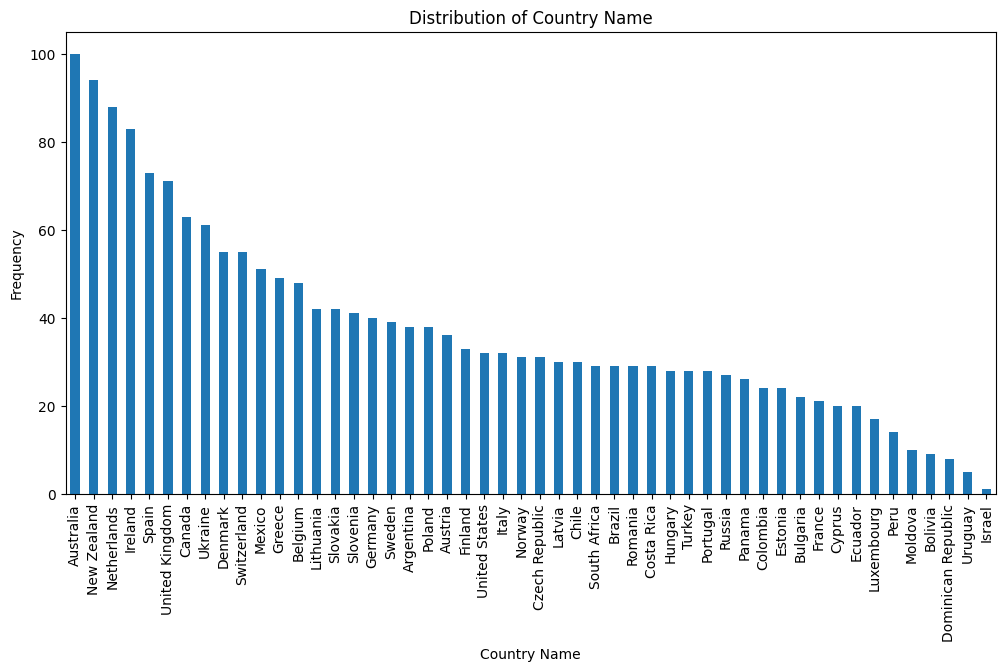

In [17]:
distribution = manifestos['country_name'].value_counts()
plt.figure(figsize=(12, 6))
distribution.plot(kind='bar')
plt.xlabel('Country Name')
plt.ylabel('Frequency')
plt.title('Distribution of Country Name')
plt.show()

### (iii) Check distribution of "party_name" for one country

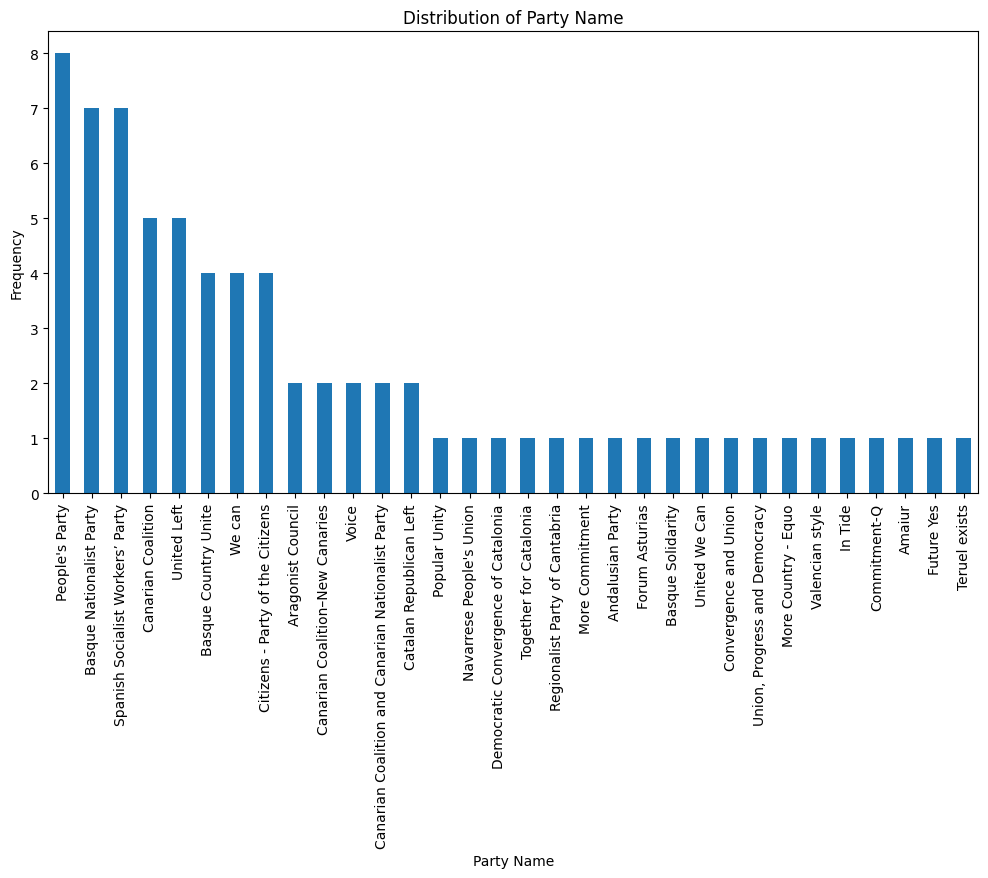

In [18]:
distribution = manifestos[manifestos['country_name'] == 'Spain']['party_name'].value_counts()
plt.figure(figsize=(12, 6))
distribution.plot(kind='bar')
plt.xlabel('Party Name')
plt.ylabel('Frequency')
plt.title('Distribution of Party Name')
plt.show()

## b. Preparing "metadata"

### (i) Filtering for only columns of interests

In [19]:
metadata = metadata[['cmp_id', 'lrgen', 'year']]
print(metadata.head())

    cmp_id     lrgen  year
0      NaN  9.888889  1999
1  21521.0  5.777778  1999
2  21421.0  7.111111  1999
3  21422.0  6.666667  1999
4  21913.0  5.125000  1999


### (ii) Remove NaN

In [20]:
# Checking the percentage of missing values
metadata_info = pd.DataFrame({
    "Column Name": metadata.columns,
    "% Missing Values": metadata.isnull().mean()
})
 

print(tabulate(metadata_info, headers="keys", tablefmt="grid"))

+--------+---------------+--------------------+
|        | Column Name   |   % Missing Values |
+========+===============+====================+
| cmp_id | cmp_id        |           0.191472 |
+--------+---------------+--------------------+
| lrgen  | lrgen         |           0        |
+--------+---------------+--------------------+
| year   | year          |           0        |
+--------+---------------+--------------------+


In [21]:
# Remove rows where 'cmp_id' is missing
metadata= metadata.dropna(subset=['cmp_id'])

# 2) Merge Data 

## a. Merge Manifestos with Metadata

In [22]:
# prepare df for merging asof

# rename party column in metadata
metadata.rename(columns={"cmp_id":"party"}, inplace=True)

# equalize datatypes of PK/FK
manifestos['election_year'] = pd.to_numeric(manifestos['election_year'], errors='coerce').astype(int)
metadata['year'] = pd.to_numeric(metadata['year'], errors='coerce').astype(int)

manifestos['party'] = pd.to_numeric(manifestos['party'], errors='coerce').astype(int)
metadata['party'] = pd.to_numeric(metadata['party'], errors='coerce').astype(int)


# Ensure both DataFrames are sorted by year before using merge_asof
manifestos = manifestos.sort_values(by=['election_year', 'party'])
metadata = metadata.sort_values(by=['year', 'party'])

In [23]:
print("rows old_df: ",len(manifestos))

# Perform merge_asof
df = pd.merge_asof(
    left=manifestos, 
    right=metadata, 
    left_on='election_year',   # Sorting column in manifestos
    right_on='year',           # Sorting column in metadata
    by=['party'],              # Additional match condition
    direction='forward'        # Matches with the closest in forward direction
    )

print("rows new_df: ",len(df))


rows old_df:  1874
rows new_df:  1874


## b. Filter European Countries & Election Year

In [11]:
european_countries = [
    'Sweden', 'Norway', 'Denmark', 'Finland', 'Belgium', 'Netherlands', 
    'Luxembourg', 'France', 'Italy', 'Spain', 'Greece', 'Portugal', 
    'Germany', 'Austria', 'Switzerland', 'United Kingdom', 'Ireland', 
    'Cyprus', 'Turkey', 'Bulgaria', 'Czech Republic', 'Estonia', 
    'Hungary', 'Latvia', 'Lithuania', 'Moldova', 'Poland', 'Romania', 
    'Russia', 'Slovakia', 'Slovenia', 'Ukraine'
]


df_full = df[df['country_name'].isin(european_countries)]

In [ ]:
df['election_year'] = df['election_year'].astype(int)
start_year, end_year = 1997, 2022
df_full = df[(df['election_year'] >= start_year) & (df['election_year'] <= end_year)]

## c. Verify Structure

In [13]:
# Checking the percentage of distinct values
def check_distinct_values(df):
    distinct_info = pd.DataFrame({
        "Column Name": df.columns,
        "% Distinct Values": df.nunique() / len(df)
    })
    print(tabulate(distinct_info, headers="keys", tablefmt="grid"))

check_distinct_values(df_full)

+---------------+---------------+---------------------+
|               | Column Name   |   % Distinct Values |
+===============+===============+=====================+
| party         | party         |           0.383648  |
+---------------+---------------+---------------------+
| text          | text          |           0.996855  |
+---------------+---------------+---------------------+
| country       | country       |           0.0251572 |
+---------------+---------------+---------------------+
| date          | date          |           0.128931  |
+---------------+---------------+---------------------+
| country_name  | country_name  |           0.0251572 |
+---------------+---------------+---------------------+
| party_name    | party_name    |           0.374214  |
+---------------+---------------+---------------------+
| election_year | election_year |           0.0408805 |
+---------------+---------------+---------------------+
| lrgen         | lrgen         |           0.26

In [ ]:
# Checking the percentage of missing values
df_full_info = pd.DataFrame({
    "Column Name": df_full.columns,
    "% Missing Values": df_full.isnull().mean()
})
 

print(tabulate(df_full_info, headers="keys", tablefmt="grid"))

+---------------+---------------+--------------------+
|               | Column Name   |   % Missing Values |
+===============+===============+====================+
| party         | party         |           0        |
+---------------+---------------+--------------------+
| text          | text          |           0        |
+---------------+---------------+--------------------+
| country       | country       |           0        |
+---------------+---------------+--------------------+
| date          | date          |           0        |
+---------------+---------------+--------------------+
| country_name  | country_name  |           0        |
+---------------+---------------+--------------------+
| party_name    | party_name    |           0        |
+---------------+---------------+--------------------+
| election_year | election_year |           0        |
+---------------+---------------+--------------------+
| lrgen         | lrgen         |           0.625786 |
+---------

# 3) Preprocessing

## a. Define Preprocessing Functions

We define several preprocessing functions to clean and transform text, and we have selected the below methods:
- Pre-trained **spaCy model** (en_core_web_sm) for **lemmatization**.
- **SnowballStemmer** (from nltk) for **stemming**.

In [16]:
# Custom dictionary with a list of **stop-words** selected based on testing. 

STOP_WORDS = set(stopwords.words('english'))

# Custom stop words related to politics
custom_stopwords = {'see', 'people'}

STOP_WORDS.update(custom_stopwords)

### (i) *Lowercasing & Stopword Removal (`preprocess_lower`)*
- Converts text to **lowercase**.
- **Removes punctuation** and tokenizes words.
- **Filters out stopwords** (default + stopwords).


In [17]:
def preprocess_lower(text):
    
    # Lowercase the text
    text_lower = text.lower()

    # Remove punctuation (everything except word characters and whitespace)
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)

    # Tokenize the cleaned text
    tokens = word_tokenize(text_no_punct)

    return " ".join(tokens)

### (ii) *Stemming (`preprocess_stem`)*
- Applies **stemming** using the **Porter Stemmer**.
- Uses preprocessed text from preprocess_lower and reduces words to their root forms.

In [18]:
def preprocess_stem(text):
    # Get the cleaned text from preprocess_lower
    text_clean = preprocess_lower(text)  

    # Tokenize once
    tokens = word_tokenize(text_clean)

    # Initialize the Porter Stemmer
    porter = SnowballStemmer("english")

    # Stem each token
    stemmed_tokens = [porter.stem(token) for token in tokens]

    return " ".join(stemmed_tokens)

### (iii) *Lemmatization (`preprocess_lemma`)*
- Uses **spaCy** to extract the **lemma** of each token.
- Removes **stopwords and punctuation** for cleaner text.

In [19]:
sp = spacy.load("en_core_web_sm")

def preprocess_lemma(text):

    # Process text using spaCy
    doc = sp(text)

    # Extract the lemma of each token, filtering out tokens flagged as punctuation or stopwords.
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_.strip() != '']

    return " ".join(lemmatized_tokens)

## b. Apply Functions Sequentially

In [ ]:
df_full['text_no_stopwords']= df_full['text'].progress_apply(lambda x: preprocess_lower(x) if pd.notna(x) else "")
df_full['text_stem']= df_full['text_no_stopwords'].progress_apply(lambda x: preprocess_stem(x) if pd.notna(x) else "")
df_full['text_lemma']= df_full['text_no_stopwords'].progress_apply(lambda x: preprocess_lemma(x) if pd.notna(x) else "")

100%|██████████| 71/71 [00:03<00:00, 21.45it/s]
/var/folders/g4/x55k_72x38zgfktpn2kkcg6m0000gn/T/ipykernel_85187/1880637676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spain['text_no_stopwords']= df_spain['text'].progress_apply(lambda x: preprocess_lower(x) if pd.notna(x) else "")
100%|██████████| 71/71 [04:40<00:00,  3.95s/it]
/var/folders/g4/x55k_72x38zgfktpn2kkcg6m0000gn/T/ipykernel_85187/1880637676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spain['text_lemma']= df_spain['text_no_s

## c. Export

In [ ]:
df_full.to_csv("df_full_preprocessed.csv", index=False, encoding="utf-8")

# 4) Import Preprocessed CSV

In [40]:
df_full = pd.read_csv('df_full_preprocessed.csv')

## a. Verify Structure

### (i) Check Structure

In [41]:
# Checking the percentage of distinct values
def check_distinct_values(df):
    distinct_info = pd.DataFrame({
        "Column Name": df.columns,
        "% Distinct Values": df.nunique() / len(df)
    })
    print(tabulate(distinct_info, headers="keys", tablefmt="grid"))

check_distinct_values(df_full)

+-------------------+-------------------+---------------------+
|                   | Column Name       |   % Distinct Values |
+===================+===================+=====================+
| party             | party             |          0.363927   |
+-------------------+-------------------+---------------------+
| text              | text              |          0.993063   |
+-------------------+-------------------+---------------------+
| country           | country           |          0.0266809  |
+-------------------+-------------------+---------------------+
| date              | date              |          0.135539   |
+-------------------+-------------------+---------------------+
| country_name      | country_name      |          0.0266809  |
+-------------------+-------------------+---------------------+
| party_name        | party_name        |          0.372465   |
+-------------------+-------------------+---------------------+
| election_year     | election_year     

In [42]:
# Checking the percentage of missing values
df_full_info = pd.DataFrame({
    "Column Name": df_full.columns,
    "% Missing Values": df_full.isnull().mean()
})
 

print(tabulate(df_full_info, headers="keys", tablefmt="grid"))

+-------------------+-------------------+--------------------+
|                   | Column Name       |   % Missing Values |
+===================+===================+====================+
| party             | party             |            0       |
+-------------------+-------------------+--------------------+
| text              | text              |            0       |
+-------------------+-------------------+--------------------+
| country           | country           |            0       |
+-------------------+-------------------+--------------------+
| date              | date              |            0       |
+-------------------+-------------------+--------------------+
| country_name      | country_name      |            0       |
+-------------------+-------------------+--------------------+
| party_name        | party_name        |            0       |
+-------------------+-------------------+--------------------+
| election_year     | election_year     |            0 

### (ii) Check Distribution of Election_Year

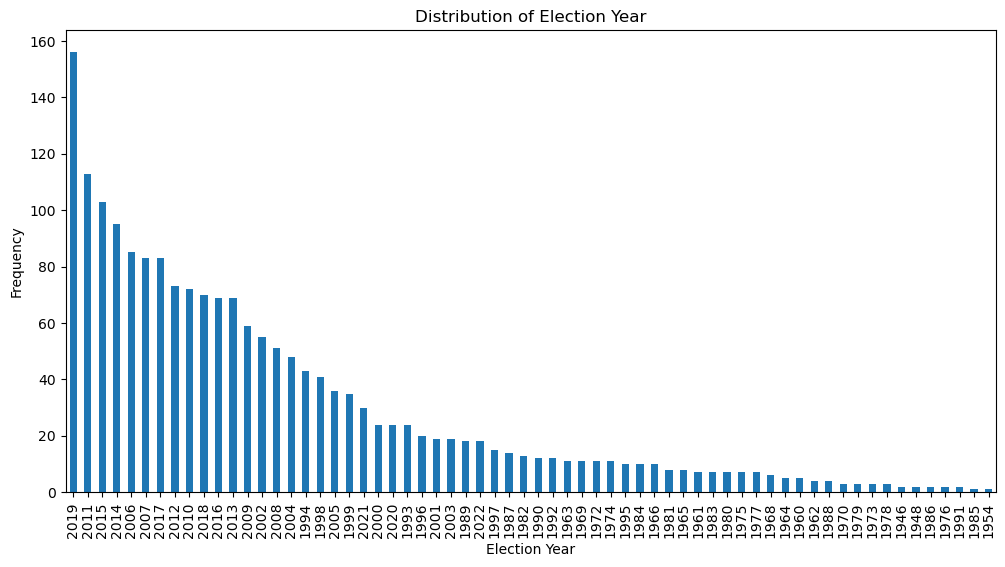

In [43]:
distribution = df_full['election_year'].value_counts()
plt.figure(figsize=(12, 6))
distribution.plot(kind='bar')
plt.xlabel('Election Year')
plt.ylabel('Frequency')
plt.title('Distribution of Election Year')
plt.show()

## b. Filter for European Countries and Election Year

In [116]:
countries = ['Netherlands', 'Ireland', 'United Kingdom', 'France', 'Slovakia', 'Poland',
 'Bulgaria', 'Spain', 'Greece', 'Romania', 'Denmark', 'Germany', 'Hungary',
 'Portugal', 'Austria', 'Estonia', 'Lithuania', 'Italy', 'Czech Republic',
 'Luxembourg', 'Slovenia', 'Sweden', 'Cyprus','Latvia','Finland', 'Belgium']

In [117]:
# filter df_full for the countries in the list
df_full = df_full[df_full['country_name'].isin(countries)]
df_full.shape

(1060, 13)

In [119]:
#filter df_full for election_year > 1997
df_full = df_full[df_full['election_year'] > 1997]
df_full.shape

(927, 13)

In [120]:
# get observations where lrgen is missing
df_full_missing = df_full[df_full['lrgen'].isnull()]
df_full_missing.shape

(250, 13)

In [122]:
df_full_no_missing = df_full.dropna(subset=['lrgen'])
df_full_no_missing.shape

(677, 13)

In [124]:
# filter df_full_missing to only include party_names that are in df_full_no_missing
df_full_missing = df_full_missing[df_full_missing['party_name'].isin(df_full_no_missing['party_name'])]
df_full_missing.shape   

(54, 13)

In [108]:
df_full = df_full[df_full['lrgen'].notnull()].copy()
df_full.reset_index(drop=True, inplace=True)
print(f"Remaining rows: {len(df_full)}")

Remaining rows: 763


## c. Round "lrgen"

In [6]:
# create new column lrgend_rounded that rounds the lrgen values to the nearest integer
df_full['lrgen_rounded'] = df_full['lrgen'].round().astype(int)

# 5) Predict "lr gen" as Continuous Variable

## a. TF-IDF + Linear Regression

In [111]:
# Separate rows with known lrgen values
df_train = df_full[df_full['lrgen'].notnull()].copy()

# Prepare features and target
X = df_train['text_lemma']      # switching this input affects the whole dynamics
y = df_train['lrgen'].astype(float)

# Split into training and testing sets (25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Build a simple pipeline: TF-IDF (with unigrams and bigrams) + Linear Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
    ('regressor', LinearRegression())
])

# Train on the training split
pipeline.fit(X_train, y_train)

# Evaluate the model on the test split
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R^2: {r2:.3f}")

Test RMSE: 1.021
Test R^2: 0.803


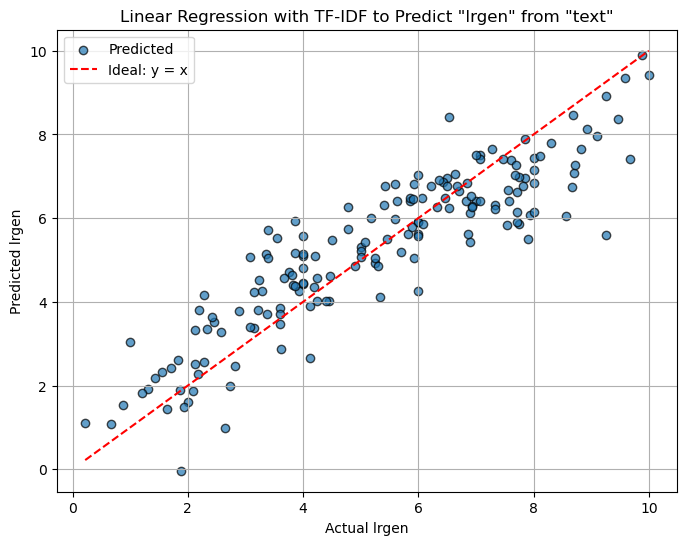

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal: y = x')
plt.xlabel('Actual lrgen')
plt.ylabel('Predicted lrgen')
plt.title('Linear Regression with TF-IDF to Predict "lrgen" from "text"')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract the TfidfVectorizer and Linear Regression model from the pipeline
tfidf_vectorizer = pipeline.named_steps['tfidf']
linear_regressor = pipeline.named_steps['regressor']

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the coefficients from the Linear Regression model
coefficients = linear_regressor.coef_

# Create a DataFrame to organize the features and their coefficients
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort features by coefficient (from highest to lowest)
coef_df_sorted = coef_df.sort_values(by='coefficient', ascending=False)

# Display the top 10 features that push the lrgen score higher (right-leaning)
print("Top 10 positive features:")
print(coef_df_sorted.head(10))

# Display the top 10 features that push the lrgen score lower (left-leaning)
print("\nTop 10 negative features:")
print(coef_df_sorted.tail(10))

Top 10 positive features:
          feature  coefficient
4871       jobbik     4.391799
4346  immigration     3.810833
7448       reform     3.726814
3706       french     3.448189
2068      cypriot     3.442600
6572          pln     3.413875
3351       family     3.339871
3596      foreign     3.190537
4004        greek     2.893031
6074           od     2.845776

Top 10 negative features:
           feature  coefficient
7111        public    -3.272438
2944  enhedslisten    -3.425974
8163            sf    -3.441506
5024           lds    -3.842202
6719       poverty    -3.916955
9653          wage    -4.162624
8315        social    -4.389069
6406          pdsr    -4.538300
4921           kke    -4.541891
7752         right    -6.900120


## b. TF-IDF + Random Forest

Test RMSE: 1.605
Test R^2: 0.467


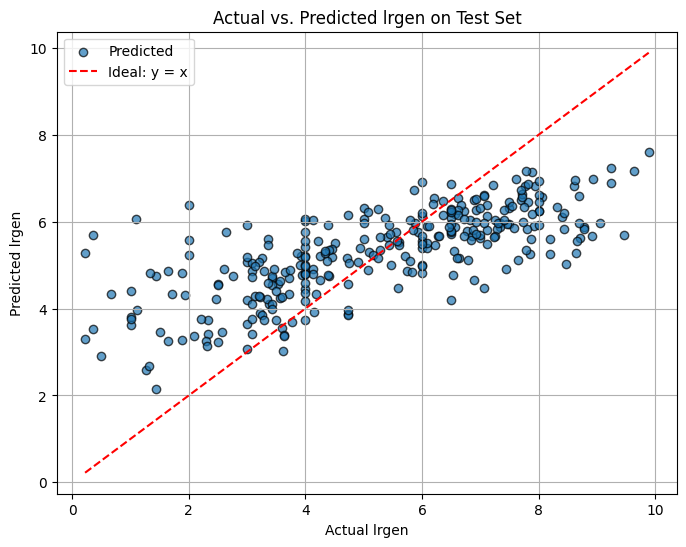

In [240]:
# Separate rows with known lrgen values
df_train = df_full[df_full['lrgen'].notnull()].copy()

# Prepare features and target
X = df_train['text']
y = df_train['lrgen'].astype(float)

# Split into training and testing sets (40% test set as given)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Build a pipeline: TF-IDF (with unigrams and bigrams) + Random Forest Regressor
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train on the training split
pipeline.fit(X_train, y_train)

# Evaluate the model on the test split
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R^2: {r2:.3f}")

# Plot actual vs. predicted lrgen on the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal: y = x')
plt.xlabel('Actual lrgen')
plt.ylabel('Predicted lrgen')
plt.title('Actual vs. Predicted lrgen on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# 6) Classification Into 2 Discrete Groups


## a. Splitting into left < lrgen = 5

In [ ]:
# get left dummy for rows with lregen <5
df_full['left'] = np.where(df_full['lrgen_rounded'] < 5, 1, 0)

df_full['left'].value_counts()

In [ ]:
X = df_full['text_lemma']  # raw text data
y = df_full['left']

# Split the data: 75% for training (and tuning) and 25% for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## b. Random Forest with Hyperparameters

In [ ]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", RandomForestClassifier()),
    ]
)

# Parameter distributions (same as before)
parameters = {
    "vect__max_df": [0.4, 0.6, 0.8],
    "vect__min_df": [0.01, 0.03, 0.05],  
    "vect__ngram_range": [(1,1), (1,2), (2,2)],  # unigrams, unigrams+bigrams, or bigrams only
    "tfidf__use_idf": [True, False],
    'tfidf__norm': ['l1'],
    "clf__max_depth": [None, 10, 20, 30],
    "clf__n_estimators": [100, 200, 300],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__class_weight": ["balanced"],
}

# Create a RandomizedSearchCV object; n_iter controls how many parameter combinations to try.
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=parameters, 
    n_iter=20,           # Adjust this number as needed
    n_jobs=4, 
    scoring='f1_macro', 
    cv=3, 
    verbose=3,
    random_state=42
)

print("Performing random search on training data...")
print("Pipeline steps:", [name for name, _ in pipeline.steps])
print("Parameters:")
print(parameters)

t0 = time.time()
random_search.fit(X_train, y_train)
print("Done in %0.3fs" % (time.time() - t0))
print()

print("Best score: %0.3f" % random_search.best_score_)
print("Best parameters set for label 1:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [140]:
# Extract the best estimator from grid search
best_model = random_search.best_estimator_

# Extract the components from the pipeline
vect = best_model.named_steps['vect']         # CountVectorizer
clf = best_model.named_steps['clf']           # RandomForestClassifier

# Get the feature names from the vectorizer
feature_names = vect.get_feature_names_out()

# Get the feature importances from the classifier
importances = clf.feature_importances_

# Combine into a DataFrame for easier viewing
import pandas as pd

feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_importance_df.head(30))

                 feature  importance
9645          inequality    0.008140
7865              gender    0.007243
5088         disarmament    0.006999
14809        progressive    0.006005
5367          ecological    0.005739
16508          rich poor    0.005549
8504                halt    0.005540
19855        trade union    0.005128
13705          pesticide    0.005128
15614          real wage    0.004953
6856        exploitation    0.004868
7859                 gay    0.004598
15466             racism    0.004210
16506               rich    0.004159
20909      welfare state    0.004105
17782      social europe    0.003968
16477            reverse    0.003802
1326           arm trade    0.003744
3717         cooperative    0.003686
17808     social justice    0.003654
21271  working condition    0.003637
17577           sickness    0.003621
1438             attract    0.003590
5309             dumping    0.003572
17772  social ecological    0.003564
16643            rightwe    0.003500
1

Test Accuracy: 0.801
Test ROC AUC: 0.862

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        80
           1       0.87      0.61      0.72        56

    accuracy                           0.80       136
   macro avg       0.82      0.77      0.78       136
weighted avg       0.81      0.80      0.79       136



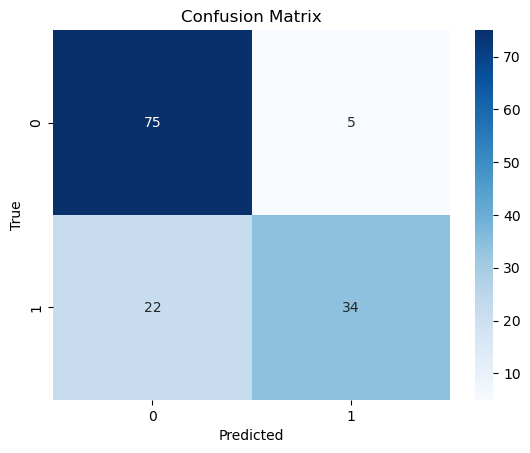

In [ ]:
# Use the best estimator found during the random search to predict on the test set
best_model = random_search.best_estimator_

# Predict class labels on the test set
y_test_pred = best_model.predict(X_test)

# If you want to evaluate ROC AUC, you'll need the predicted probabilities
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test ROC AUC: {roc_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## c. Light GBM with Hyperparameters

In [ ]:
# Define the pipeline with LightGBM as the classifier
pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", LGBMClassifier(random_state=42))
])

# Define parameter distributions for both text processing and LightGBM
parameters = {
    # CountVectorizer parameters
    "vect__max_df": [0.4, 0.6, 0.8],
    "vect__min_df": [0.01, 0.03, 0.05],
    "vect__ngram_range": [(1, 1), (1, 2), (2, 2)],  # unigrams, unigrams+bigrams, or bigrams only
    # TfidfTransformer parameters
    "tfidf__use_idf": [True, False],
    "tfidf__norm": ['l1'],
    # LightGBM parameters
    "clf__num_leaves": [31, 50, 100],
    "clf__max_depth": [-1, 10, 20, 30],  # -1 means no limit
    "clf__n_estimators": [100, 200, 300],
    "clf__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "clf__boosting_type": ["gbdt", "dart"],
    "clf__class_weight": [None, "balanced"],
}

# Create a RandomizedSearchCV object; n_iter controls how many random combinations to try
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=parameters, 
    n_iter=30,           # Adjust based on compute and coverage needs
    n_jobs=4, 
    scoring='roc_auc',   # Using ROC AUC if you're evaluating classification performance
    cv=3, 
    verbose=3,
    random_state=42
)

print("Performing random search with LightGBM...")
t0 = time.time()
random_search.fit(X_train, y_train)  # X_train and y_train should be your training data
print("Done in %0.3fs" % (time.time() - t0))
print()

print("Best score: %0.3f" % random_search.best_score_)

In [160]:
# Extract the best estimator from your randomized search
best_model = random_search.best_estimator_

# Retrieve the CountVectorizer (named 'vect') and the LightGBM classifier (named 'clf') from the pipeline
vect = best_model.named_steps['vect']
clf = best_model.named_steps['clf']

# Get the feature names generated by the CountVectorizer
feature_names = vect.get_feature_names_out()

# Extract the feature importances from the LightGBM classifier
importances = clf.feature_importances_

# Combine the feature names and importances into a DataFrame for easier analysis
import pandas as pd
feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_importance_df.head(20))

                feature  importance
109945          poverty         168
74406        inequality          94
49245      entrepreneur          64
160852          working          52
91795      minimum wage          46
21987         christian          45
42941        ecological          45
70212       immigration          44
34109          criminal          40
153550       understand          38
37838        democratic          35
160779     worker right          35
3176             accord          32
41202    discrimination          31
114293           profit          26
151116      trade union          25
26426   competitiveness          25
11612           attract          24
143537     subsidiarity          22
69880          identity          21


/opt/anaconda3/envs/BSE/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/BSE/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Test Accuracy: 0.853
Test ROC AUC: 0.927

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        80
           1       0.91      0.71      0.80        56

    accuracy                           0.85       136
   macro avg       0.87      0.83      0.84       136
weighted avg       0.86      0.85      0.85       136



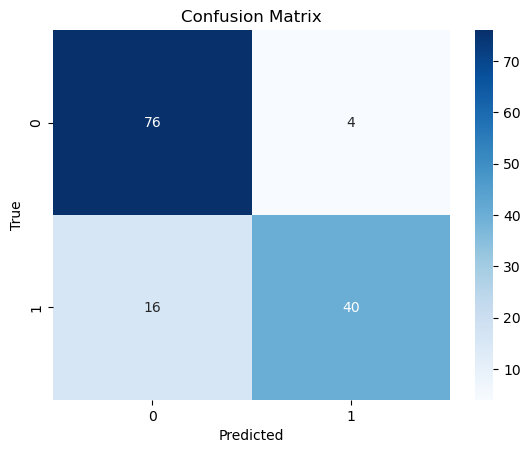

In [ ]:
best_model = random_search.best_estimator_

# Predict class labels on the test set
y_test_pred = best_model.predict(X_test)

# If you want to evaluate ROC AUC, you'll need the predicted probabilities
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test ROC AUC: {roc_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## d. Extract Misclassified Observations

In [ ]:
# Get the best model from grid search
best_model = random_search.best_estimator_

# Predict labels on the test set using the best model
y_pred = best_model.predict(X_test)

# Identify misclassified indices where the prediction doesn't match the true label
misclassified_indices = np.where(y_pred != y_test)[0]

# If X_test is a pandas Series, extract the corresponding raw text observations
# Create a DataFrame with misclassified observations
misclassified_df = pd.DataFrame({
    'text': X_test.iloc[misclassified_indices],
    'true_label': y_test.iloc[misclassified_indices],
    'predicted_label': y_pred[misclassified_indices]
    'party_name': df.loc[idx_test[misclassified_indices], 'party_name'],
    'lrgen' : df.loc[idx_test[misclassified_indices], 'lrgen'],
    'election_year' : df.loc[idx_test[misclassified_indices], 'election_year'],
    'lrgen_rounded' : df.loc[idx_test[misclassified_indices], 'lrgen_rounded'],
    'country_name' : df.loc[idx_test[misclassified_indices], 'country_name']
})

print("Misclassified Observations:")
print(misclassified_df.head())

Misclassified Observations:
                                                  text  true_label  \
732  country fight government spanish capitalism un...         2.0   
422  foreword history 15 year race february 1996 sm...         5.0   
149  progressive democrats manifesto 2002 content i...         8.0   
453  dear friend freedom chinese indulgence live in...         9.0   
187  social liberal party work reform futureproof w...         5.0   

     predicted_label  
732                1  
422                0  
149                0  
453                0  
187                0  


# 7) Classification Into 3 Discrete Groups


Load and prepare data.

In [20]:
df_full = pd.read_csv('df_full_preprocessed.csv')

In [21]:
# filter df_full for only rows with election_year > 1997
df_full = df_full[df_full['election_year'] > 1997].copy()

# filter df_full for only rows with known lrgen values
df_full = df_full[df_full['lrgen'].notnull()].copy()

df_full.shape

(677, 12)

## a. Split at left > 3.5 < center > 6.5 < right

In [22]:
# Define the bins and labels
bins = [-np.inf, 3.5, 6.5, np.inf]
labels = ['left', 'center', 'right']

# Create a new column with the political position
df_full['political_position'] = pd.cut(df_full['lrgen'], bins=bins, labels=labels)

In [23]:
# count values for left, center and right
df_full['political_position'].value_counts()

political_position
center    262
right     241
left      174
Name: count, dtype: int64

## b. Explore Document Term Matrix

In [24]:
cv = CountVectorizer(ngram_range = (1,2))
cv.fit(df_full['text_lemma'])
vectorized_text=cv.transform(df_full['text_lemma'])
names=np.array(cv.get_feature_names_out())
print("dimensions of DT matrix are", vectorized_text.shape)

dimensions of DT matrix are (677, 2696175)


In [194]:
cv = CountVectorizer(ngram_range = (1,1), min_df=0.01, max_df=0.8)
cv.fit(df_full['text_lemma'])
vectorized_text=cv.transform(df_full['text_lemma'])
names=np.array(cv.get_feature_names_out())
print("dimensions of DT matrix are", vectorized_text.shape)

dimensions of DT matrix are (677, 16991)


In [195]:
cv = CountVectorizer(ngram_range = (1,2), min_df=0.05, max_df=0.8)
cv.fit(df_full['text_lemma'])
vectorized_text=cv.transform(df_full['text_lemma'])
names=np.array(cv.get_feature_names_out())
print("dimensions of DT matrix are", vectorized_text.shape)

dimensions of DT matrix are (677, 23257)


In [196]:
cv = CountVectorizer(ngram_range = (1,2), min_df=0.1, max_df=0.6)
cv.fit(df_full['text_lemma'])
vectorized_text=cv.transform(df_full['text_lemma'])
names=np.array(cv.get_feature_names_out())
print("dimensions of DT matrix are", vectorized_text.shape)

dimensions of DT matrix are (677, 8917)


## c. Splitting into Train and Test

In [201]:
# Split the full DataFrame to preserve all metadata
df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42)

# For training, extract the text and target
X_train = df_train['text_lemma']  # raw text used for training
y_train = df_train['political_position']        # political position

# For testing, extract the text and target; the full df_test still has metadata
X_test = df_test['text_lemma']    # raw text used for prediction
y_test = df_test['political_position']  # true political position


## d. Light GBM with Hyperparameters

In [ ]:
# Define the pipeline with LightGBM as the classifier
pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", LGBMClassifier(random_state=42))
])

# Define parameter distributions for both text processing and LightGBM
parameters = {
    # CountVectorizer parameters
    "vect__max_df": [0.6, 0.8 , 1.0],
    "vect__min_df": [0.05, 0.08, 0.1, 0.15],
    "vect__ngram_range": [(1, 1), (1, 2), (2, 2)],  # unigrams, unigrams+bigrams, or bigrams only
    # TfidfTransformer parameters
    "tfidf__use_idf": [True, False],
    "tfidf__norm": ['l1'],
    # LightGBM parameters
    "clf__num_leaves": [50, 100],
    "clf__max_depth": [10, 20],
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "clf__boosting_type": ["dart"],
    "clf__class_weight": [None, "balanced"],
}

# Create a RandomizedSearchCV object; adjust n_iter based on your compute resources
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=parameters, 
    n_iter=20,           # number of random combinations to try
    n_jobs=4, 
    scoring='accuracy',  # or use 'f1_macro' if you prefer
    cv=3, 
    verbose=3,
    random_state=42
)

print("Performing random search with LightGBM for multiclass classification...")
t0 = time.time()
random_search.fit(X_train, y_train)
print("Done in %0.3fs" % (time.time() - t0))
print()

print("Best score: %0.3f" % random_search.best_score_)
print("Best parameters:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
# Create a pipeline with the best hyperparameters
best_pipeline = Pipeline([
    ("vect", CountVectorizer(max_df=0.8, min_df=0.1, ngram_range=(1, 2))),
    ("tfidf", TfidfTransformer(use_idf=True, norm='l1')),
    ("clf", LGBMClassifier(
        boosting_type='dart',
        class_weight='balanced',
        learning_rate=0.2,
        max_depth=20,
        n_estimators=200,
        num_leaves=100,
        random_state=42
    ))
])

# Fit the model on your training data (X_train and y_train)
best_pipeline.fit(X_train, y_train)

In [203]:
# Retrieve the CountVectorizer and the classifier from the pipeline
vect = best_pipeline.named_steps['vect']
clf = best_pipeline.named_steps['clf']

# Get feature names and feature importances
feature_names = vect.get_feature_names_out()
importances = clf.feature_importances_

# Create a DataFrame to display the top features
feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Top 20 important features:")
print(feat_importance_df.head(20))

Top 20 important features:
              feature  importance
6086          poverty         283
8414      trade union         205
1758         criminal         147
9042          working         147
4120       inequality         121
3323   freedom choice          98
5715    participation          90
1374  competitiveness          84
2199   discrimination          79
7734        stability          76
876             breed          68
3901      immigration          67
668           attract          67
225             abuse          64
4797             main          57
1370      competitive          56
2352       ecological          55
3900        immigrant          54
5504          officer          53
2752  environmentally          49


Test Accuracy: 0.728
Classification Report:
              precision    recall  f1-score   support

        left       0.72      0.66      0.69        59
      center       0.70      0.70      0.70        30
       right       0.75      0.83      0.79        47

    accuracy                           0.73       136
   macro avg       0.72      0.73      0.73       136
weighted avg       0.73      0.73      0.73       136



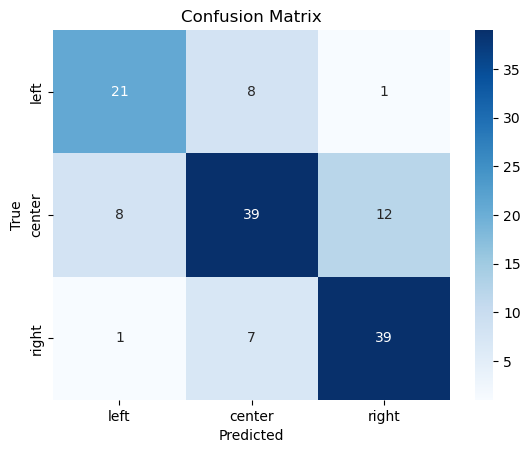

In [ ]:
# Define the class names in the order you expect them
class_names = ['left', 'center', 'right']

# Evaluate performance
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Compute the confusion matrix with the specified label order
cm = confusion_matrix(y_test, y_test_pred, labels=class_names)

# Plot the confusion matrix with custom tick labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [121]:
# count elements in y_test
y_test.value_counts()

political_position
center    59
right     47
left      30
Name: count, dtype: int64

In [ ]:
# Create a DataFrame to display the top features (already computed as feat_importance_df)
top_features = feat_importance_df.head(20)

# Plot the feature importances using a horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features, palette="viridis")
plt.title("Top 20 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## e. Analyze Misclassified

In [ ]:
# Identify indices where predictions do not match the true labels
misclassified_indices = np.where(y_test != y_test_pred)[0]

# Create a DataFrame that includes misclassified observations along with metadata
misclassified_df = pd.DataFrame({
    'text_lemma': df_test['text_lemma'].iloc[misclassified_indices],
    'country_name': df_test['country_name'].iloc[misclassified_indices],
    'party_name': df_test['party_name'].iloc[misclassified_indices],
    'lrgen': df_test['lrgen'].iloc[misclassified_indices],
    'true_label': y_test.iloc[misclassified_indices],
    'predicted_label': y_test_pred[misclassified_indices]
})

print("Mispredicted Observations with Metadata:")
misclassified_df.head()

Mispredicted Observations with Metadata:


,text_lemma,country_name,party_name,lrgen,true_label,predicted_label
596,social liberal party work reform futureproof w...,Denmark,Danish Social-Liberal Party,4.780000,center,right
709,choose welfare social democrats basis general ...,Denmark,Social Democratic Party,4.181818,center,left
979,want overhaul current quantity society quality...,Finland,Green Union,4.444445,center,left
790,new italy democratic party italy change world ...,Italy,Democratic Party,3.222222,left,center
765,introduction estonia successful fruit success ...,Estonia,Social Democratic Party,3.230769,left,center


In [208]:
# get value counts for country_name in misclassified_df
misclassified_df['country_name'].value_counts()

country_name
Denmark           5
Hungary           4
Estonia           4
Slovenia          3
Lithuania         3
Sweden            3
Netherlands       2
Italy             2
Germany           2
Czech Republic    2
Austria           1
Finland           1
Slovakia          1
United Kingdom    1
Belgium           1
Poland            1
Spain             1
Name: count, dtype: int64

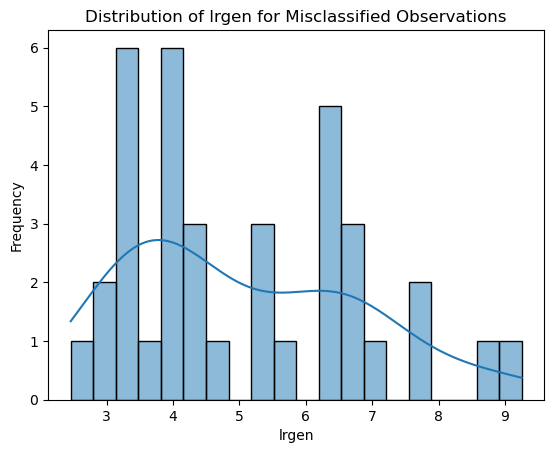

In [ ]:
# Plot a histogram with a kernel density estimate (KDE) for the 'lrgen' column
sns.histplot(misclassified_df['lrgen'], bins=20, kde=True)

plt.xlabel('lrgen')
plt.ylabel('Frequency')
plt.title('Distribution of lrgen for Misclassified Observations')
plt.show()

In [211]:
# filter misclassified_df for predicted_label = 'left' where true_label = 'right'
misclassified_df[(misclassified_df['predicted_label'] == 'left') & (misclassified_df['true_label'] == 'right')]

,text_lemma,country_name,party_name,lrgen,true_label,predicted_label
625,parent important child safe family strength so...,Sweden,Christian Democrats,6.89,right,left


## f. Random Forest with Hyperparameters


In [ ]:
# Define your pipeline as before
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", RandomForestClassifier()),
    ]
)

# Parameter distributions (same as before)
parameters = {
    "vect__max_df": [0.4, 0.6, 0.8],
    "vect__min_df": [0.03, 0.05, 0.08, 0.1],  
    "vect__ngram_range": [(1,1), (1,2), (2,2)],  # unigrams, unigrams+bigrams, or bigrams only
    "tfidf__use_idf": [True, False],
    'tfidf__norm': ['l1'],
    "clf__max_depth": [10, 20, 30],
    "clf__n_estimators": [100, 200, 300],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__class_weight": ["balanced"],
}

# Create a RandomizedSearchCV object; n_iter controls how many parameter combinations to try.
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=parameters, 
    n_iter=30,           # Adjust this number as needed
    n_jobs=4, 
    scoring='accuracy', 
    cv=3, 
    verbose=3,
    random_state=42
)

print("Performing random search on training data...")
print("Pipeline steps:", [name for name, _ in pipeline.steps])
print("Parameters:")
print(parameters)

t0 = time.time()
random_search.fit(X_train, y_train)
print("Done in %0.3fs" % (time.time() - t0))
print()

print("Best score: %0.3f" % random_search.best_score_)
print("Best parameters set for label 1:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
# Create the pipeline with the best hyperparameters
rf_pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=0.8, min_df=0.1, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(use_idf=True, norm='l1')),
    ('clf', RandomForestClassifier(
         class_weight='balanced',
         max_depth=30,
         min_samples_leaf=1,
         n_estimators=200,
         random_state=42
    ))
])

# Fit the model using the training data
rf_pipeline.fit(X_train, y_train)

# Optionally, predict on the test set and evaluate
y_test_pred_rf = rf_pipeline.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Random Forest Test Accuracy: {accuracy_rf:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

Random Forest Test Accuracy: 0.669
Classification Report:
              precision    recall  f1-score   support

      center       0.64      0.76      0.70        59
        left       0.85      0.57      0.68        30
       right       0.63      0.62      0.62        47

    accuracy                           0.67       136
   macro avg       0.71      0.65      0.67       136
weighted avg       0.68      0.67      0.67       136



Test Accuracy: 0.669
Classification Report:
              precision    recall  f1-score   support

        left       0.64      0.76      0.70        59
      center       0.85      0.57      0.68        30
       right       0.63      0.62      0.62        47

    accuracy                           0.67       136
   macro avg       0.71      0.65      0.67       136
weighted avg       0.68      0.67      0.67       136



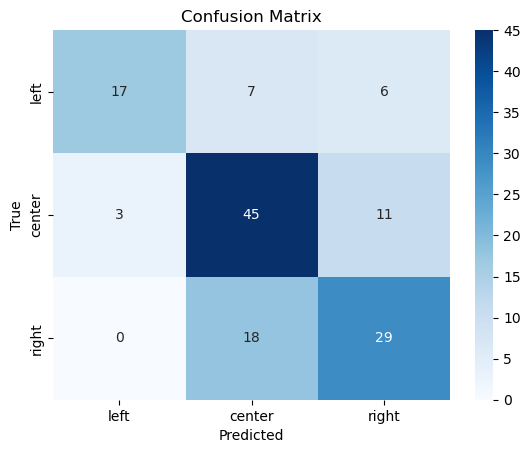

In [215]:
# Define the class names in the order you expect them
class_names = ['left', 'center', 'right']

# Evaluate performance
accuracy = accuracy_score(y_test, y_test_pred_rf)
print(f"Test Accuracy: {accuracy:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_rf, target_names=class_names))

# Compute the confusion matrix with the specified label order
cm = confusion_matrix(y_test, y_test_pred_rf, labels=class_names)

# Plot the confusion matrix with custom tick labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Top 20 important features:
                   feature  importance
6086               poverty    0.006068
9042               working    0.004827
1374       competitiveness    0.003285
8414           trade union    0.003217
2199        discrimination    0.003072
4120            inequality    0.002739
5035          minimum wage    0.002638
3900             immigrant    0.002430
7551  social environmental    0.002370
5957        police officer    0.002294
9039          worker right    0.002279
7314              sentence    0.002267
3901           immigration    0.002172
5504               officer    0.002154
1758              criminal    0.002145
1205                 class    0.002134
8841                   war    0.002065
2752       environmentally    0.002051
6497      public transport    0.002037
2765              equality    0.001965


/var/folders/yl/blfh275s3xq56mz3wkmfnrzh0000gn/T/ipykernel_60685/685552080.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20), palette="viridis")


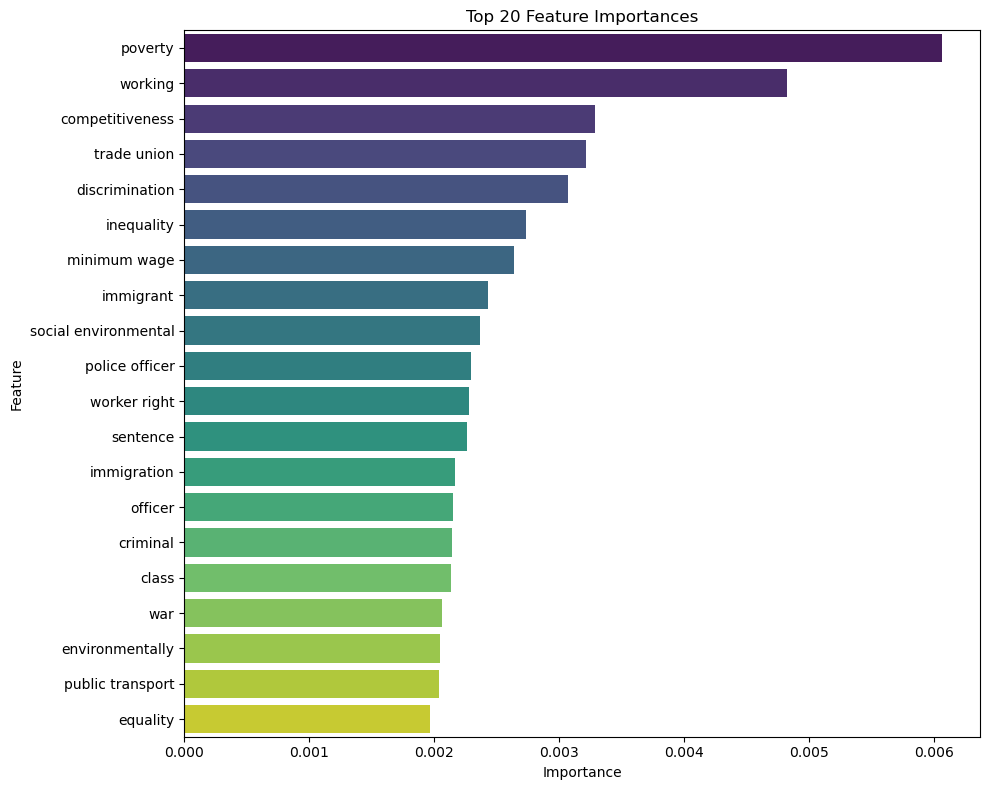

In [ ]:
# Retrieve the CountVectorizer and the classifier from the pipeline
vect = rf_pipeline.named_steps['vect']
clf = rf_pipeline.named_steps['clf']

# Get the feature names generated by the CountVectorizer
feature_names = vect.get_feature_names_out()

# Extract feature importances from the RandomForestClassifier
importances = clf.feature_importances_

# Create a DataFrame to display the features and their importance scores
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Top 20 important features:")
print(feat_imp_df.head(20))

## g. Analyze Misclassified (Part 2)

In [ ]:
y_test_pred_rf = rf_pipeline.predict(X_test)

# Identify indices where predictions do not match the true labels
misclassified_indices = np.where(y_test != y_test_pred_rf)[0]

# Create a DataFrame that includes misclassified observations along with metadata
misclassified_df = pd.DataFrame({
    'text_lemma': df_test['text_lemma'].iloc[misclassified_indices],
    'country_name': df_test['country_name'].iloc[misclassified_indices],
    'party_name': df_test['party_name'].iloc[misclassified_indices],
    'lrgen': df_test['lrgen'].iloc[misclassified_indices],
    'true_label': y_test.iloc[misclassified_indices],
    'predicted_label': y_test_pred_rf[misclassified_indices]
})

print("Mispredicted Observations with Metadata:")
misclassified_df.head()

Mispredicted Observations with Metadata:


,text_lemma,country_name,party_name,lrgen,true_label,predicted_label
476,progressive democrats manifesto 2002 content i...,Ireland,Progressive Democrats,7.750000,right,center
596,social liberal party work reform futureproof w...,Denmark,Danish Social-Liberal Party,4.780000,center,right
709,choose welfare social democrats basis general ...,Denmark,Social Democratic Party,4.181818,center,right
979,want overhaul current quantity society quality...,Finland,Green Union,4.444445,center,left
790,new italy democratic party italy change world ...,Italy,Democratic Party,3.222222,left,right


In [218]:
# get value counts for country_name in misclassified_df
misclassified_df['country_name'].value_counts()

country_name
Denmark           7
Netherlands       4
Austria           3
Spain             3
Finland           3
Czech Republic    3
Estonia           3
Hungary           3
Slovenia          3
Slovakia          2
Ireland           2
Sweden            2
Lithuania         2
Italy             2
Germany           1
Poland            1
Belgium           1
Name: count, dtype: int64

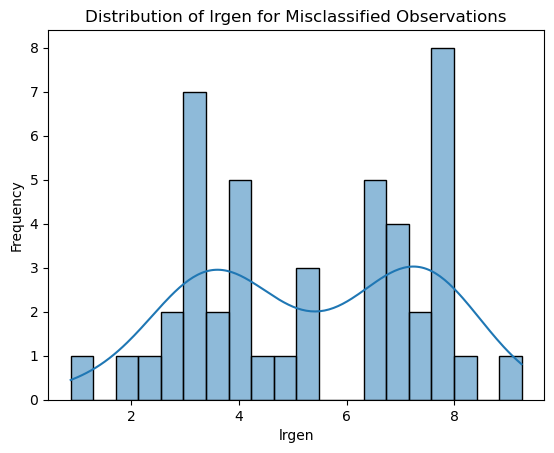

In [ ]:
# Plot a histogram with a kernel density estimate (KDE) for the 'lrgen' column
sns.histplot(misclassified_df['lrgen'], bins=20, kde=True)

plt.xlabel('lrgen')
plt.ylabel('Frequency')
plt.title('Distribution of lrgen for Misclassified Observations')
plt.show()

In [ ]:
# --- For Random Forest ---
# Obtain misclassified indices for Random Forest
rf_indices = np.where(y_test != y_test_pred_rf)[0]

# Create a DataFrame for misclassified observations (including metadata)
rf_misclassified = pd.DataFrame({
    'party_name': df_test['party_name'].iloc[rf_indices],
    'text_lemma': df_test['text_lemma'].iloc[rf_indices],
    'lrgen': df_test['lrgen'].iloc[rf_indices],
    'true_label': y_test.iloc[rf_indices],
    'rf_pred': y_test_pred_rf[rf_indices]
})

# --- For LightGBM ---
# Obtain predictions from the LightGBM pipeline (assuming best_pipeline is for LightGBM)
y_test_pred_lgbm = best_pipeline.predict(X_test)
lgbm_indices = np.where(y_test != y_test_pred_lgbm)[0]

# Create a DataFrame for misclassified observations (including metadata)
lgbm_misclassified = pd.DataFrame({
    'party_name': df_test['party_name'].iloc[lgbm_indices],
    'text_lemma': df_test['text_lemma'].iloc[lgbm_indices],
    'lrgen': df_test['lrgen'].iloc[lgbm_indices],
    'true_label': y_test.iloc[lgbm_indices],
    'lgbm_pred': y_test_pred_lgbm[lgbm_indices]
})

# --- Compare the Misclassifications ---
# Find common misclassified indices (i.e. observations misclassified by both models)
common_indices = np.intersect1d(rf_indices, lgbm_indices)

common_misclassified = pd.DataFrame({
    'party_name': df_test['party_name'].iloc[common_indices],
    'text_lemma': df_test['text_lemma'].iloc[common_indices],
    'lrgen': df_test['lrgen'].iloc[common_indices],
    'true_label': y_test.iloc[common_indices],
    'rf_pred': y_test_pred_rf[common_indices],
    'lgbm_pred': y_test_pred_lgbm[common_indices]
})

print("\nSummary:")
print(f"Number of misclassifications - Random Forest: {len(rf_indices)}")
print(f"Number of misclassifications - LightGBM: {len(lgbm_indices)}")
print(f"Number of common misclassifications: {len(common_indices)}")


Summary:
Number of misclassifications - Random Forest: 45
Number of misclassifications - LightGBM: 37
Number of common misclassifications: 27


/opt/anaconda3/envs/BSE/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# 8) Make Prediction on Missing German Values


In [179]:
X = df_full['text_lemma']
y = df_full['political_position']

In [25]:
df = pd.read_csv('df_full_preprocessed.csv')

## a. Filter for Germany 2020

In [ ]:
# filter df for country_name = germany
df_germany = df[df['country_name'] == 'Germany']

# filter for election_year > 2020
df_germany = df_germany[df_germany['election_year'] > 2020]

# exclude outlier
df_germany = df_germany[df_germany['party_name'] != 'South Schleswig Voters’ Union']
df_germany.shape

(7, 13)

## b. Light GBM

In [ ]:
# train best lightgbm model on full data
best_pipeline.fit(X, y)

# Predict on the German subset
X_germany = df_germany['text_lemma']
y_pred_germany = best_pipeline.predict(X_germany)

# Create a DataFrame with party names and predicted labels
results = pd.DataFrame({
    'party_name': df_germany['party_name'],
    'predicted_label': y_pred_germany
})

## c. Results

In [184]:
# train best lightgbm model on full data
rf_pipeline.fit(X, y)

# Predict on the German subset
X_germany = df_germany['text_lemma']
y_pred_germany = best_pipeline.predict(X_germany)

# Create a DataFrame with party names and predicted labels
results = pd.DataFrame({
    'party_name': df_germany['party_name'],
    'predicted_label': y_pred_germany
})

print(results)

                                             party_name predicted_label
1843                                 Alliance‘90/Greens            left
1844                                           The Left            left
1845                 Social Democratic Party of Germany            left
1846                              Free Democratic Party           right
1847  Christian Democratic Union/Christian Social Union          center
1849                            Alternative for Germany           right


/opt/anaconda3/envs/BSE/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# 9) Annex - (Experiments)

This section provides linguistic measure - it doesn’t necessarily imply an ideological shift. It just shows whether the two groups’ language usage is becoming more or less similar compared to the baseline.

In each of the following subsection, we apply the same procedure but we use different 'text' column:
- (i) `First Attempt` $\to$ self-convergence/divergence & overlapping vocabulary remains static
    - The plot (try to) shows how each group’s vocabulary is converging or diverging from its own 2000 baseline but I'm not satisfied.

- (ii) `Second Attempt` $\to$ self-convergence/divergence & overlapping vocabulary updated at each t
    - The plot shows how each group’s vocabulary is converging or diverging from its own 2000 baseline:
        - The divergence of the RIGHT means they introduce new words = they’re adopting different rhetoric but that rhetoric could still be consistent with right-leaning ideas.
        - The convergence of the LEFT means they reusing most their lexicon.

    - Possible interpretation:
        - Right may be responding to new issues (i.e. digital economy, migration crises) that weren’t on the radar in 2000.
        - Left might be emphasizing consistent core messages (healthcare, welfare) that date back to 2000's.

- (iii) `Third Attempt` $\to$ converging/diverging from one another over time
    - The code computes the cosine similarity between the Left & Right's cumulative centroids each year and track changes relative to a chosen baseline year:
        - If the similarity is higher than at $t_0$, we call that “convergence” (negative on the y-axis)
        - If the similarity is lower than at $t_0$, that indicates “divergence” (positive on the y-axis)


## a. Applied to `'text'`

### (i) First Attempt

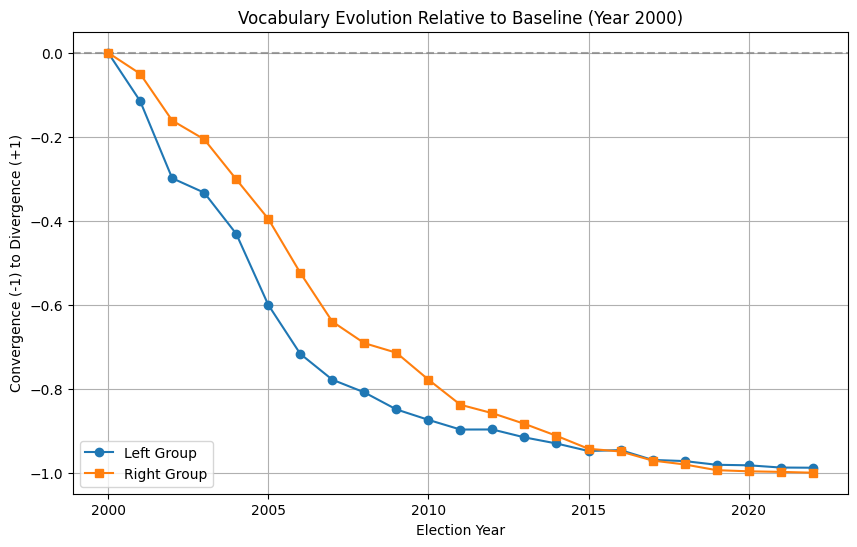

In [57]:
def transform_similarity(sim, baseline):
    """
    Maps cosine similarity 'sim' to a value in [-1, +1],
    using 'baseline' as the pivot that maps to 0.
    
    - If sim == baseline, returns 0.
    - If sim > baseline, returns negative (down to -1).
    - If sim < baseline, returns positive (up to +1).
    """
    # Edge cases: if baseline is 0 or 1, the formula can break.
    # We'll do a safe check:
    if baseline <= 0:
        # No room for negative side
        return 1 - sim  # fallback
    if baseline >= 1:
        # No room for positive side
        return sim - 1  # fallback
    
    if sim >= baseline:
        # More similarity => negative direction
        return -(sim - baseline) / (1 - baseline)
    else:
        # Less similarity => positive direction
        return (baseline - sim) / baseline

# -------------------------------------------------
# 1) Split Data & Get Overlapping Vocabulary
# -------------------------------------------------
df_left = df_full[df_full['lrgen'] <= 5].copy()
df_right = df_full[df_full['lrgen'] > 5].copy()

def get_vocabulary(text_series):
    vocab = set()
    for text in text_series:
        vocab.update(text.lower().split())
    return vocab

vocab_left = get_vocabulary(df_left['text'])
vocab_right = get_vocabulary(df_right['text'])
overlap_vocab = vocab_left.intersection(vocab_right)

vectorizer = TfidfVectorizer(vocabulary=list(overlap_vocab))

# Overall centroids for each group
tfidf_left = vectorizer.fit_transform(df_left['text'])
tfidf_right = vectorizer.fit_transform(df_right['text'])

centroid_left = tfidf_left.mean(axis=0).A.flatten()   # convert to 1D array
centroid_right = tfidf_right.mean(axis=0).A.flatten()

# -------------------------------------------------
# 2) Define a function to compute cumulative similarity
# -------------------------------------------------
def compute_cumulative_similarity(df_group, vectorizer, overall_centroid):
    """
    Returns a dict: {year: similarity}, 
    measuring how the group's cumulative centroid (up to each year)
    compares to 'overall_centroid'.
    """
    sim_by_year = {}
    for year in sorted(df_group['election_year'].unique()):
        df_cum = df_group[df_group['election_year'] <= year]
        tfidf_cum = vectorizer.transform(df_cum['text'])
        cum_centroid = tfidf_cum.mean(axis=0).A.flatten()
        sim = cosine_similarity([cum_centroid], [overall_centroid])[0][0]
        sim_by_year[year] = sim
    return sim_by_year

sim_left = compute_cumulative_similarity(df_left, vectorizer, centroid_left)
sim_right = compute_cumulative_similarity(df_right, vectorizer, centroid_right)

# -------------------------------------------------
# 3) Choose year=2000 as the baseline
# -------------------------------------------------
t0 = 2000
baseline_left = sim_left.get(t0, None)
baseline_right = sim_right.get(t0, None)

if baseline_left is None or baseline_right is None:
    raise ValueError("Year 2000 not found in one of the groups. Adjust code or pick another baseline.")

# -------------------------------------------------
# 4) Transform each similarity so that baseline=0
#    and plot from 2000 onward
# -------------------------------------------------
def transform_similarity(sim, baseline):
    if baseline <= 0:
        return 1 - sim  # fallback
    if baseline >= 1:
        return sim - 1  # fallback
    
    if sim >= baseline:
        # More similarity => negative
        return -(sim - baseline) / (1 - baseline)
    else:
        # Less similarity => positive
        return (baseline - sim) / baseline

# Build lists of (year, transformed_value) for each group
years_left = sorted(y for y in sim_left.keys() if y >= t0)
trans_left = [transform_similarity(sim_left[y], baseline_left) for y in years_left]

years_right = sorted(y for y in sim_right.keys() if y >= t0)
trans_right = [transform_similarity(sim_right[y], baseline_right) for y in years_right]

# -------------------------------------------------
# 5) Plot the results
# -------------------------------------------------
plt.figure(figsize=(10,6))
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)  # center line at y=0
plt.plot(years_left, trans_left, marker='o', label='Left Group')
plt.plot(years_right, trans_right, marker='s', label='Right Group')
plt.xlabel('Election Year')
plt.ylabel('Convergence (-1) to Divergence (+1)')
plt.title('Vocabulary Evolution Relative to Baseline (Year 2000)')
plt.legend()
plt.grid(True)
plt.show()

### (ii) Second Attempt

Initial overlapping vocabulary size (t0): 18245


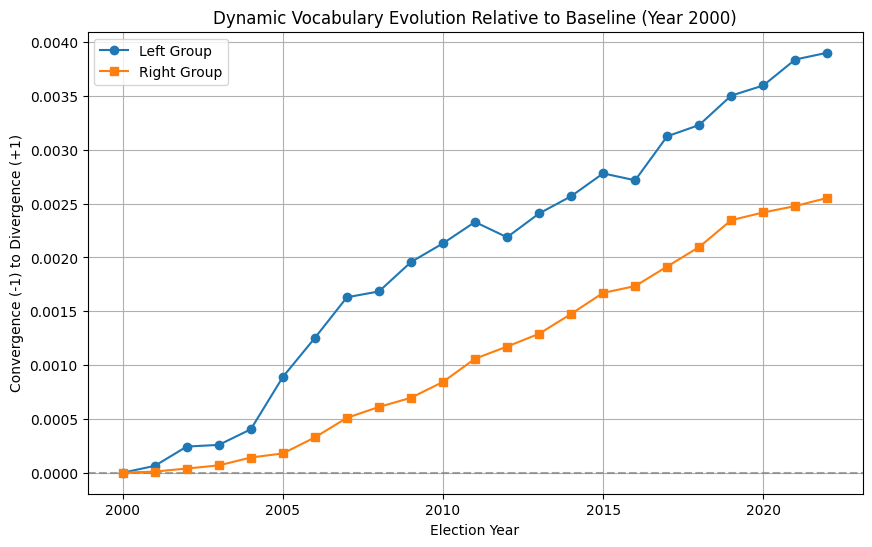

In [58]:
# =============================================================================
# Step 1: Define Helper Functions
# =============================================================================

def compute_over_common_words(df, country_col, text_col, threshold_ratio=1.5, min_freq=5):
    """
    For each country, compute words that are over-represented in that country's documents
    relative to the overall frequency.
    Returns a dictionary mapping each country to its set of over-common words.
    """
    overall_counts = {}
    total_docs = len(df)
    
    # Overall document frequency (unique tokens per document)
    for text in df[text_col]:
        tokens = set(text.lower().split())
        for token in tokens:
            overall_counts[token] = overall_counts.get(token, 0) + 1
    
    overall_prop = {word: count/total_docs for word, count in overall_counts.items() if count >= min_freq}
    
    country_over_common = {}
    for country, group in df.groupby(country_col):
        country_total = len(group)
        country_counts = {}
        for text in group[text_col]:
            tokens = set(text.lower().split())
            for token in tokens:
                if token in overall_prop:
                    country_counts[token] = country_counts.get(token, 0) + 1
        over_common_set = set()
        for token, count in country_counts.items():
            country_prop = count / country_total
            if country_prop / overall_prop[token] > threshold_ratio:
                over_common_set.add(token)
        country_over_common[country] = over_common_set
    return country_over_common

def remove_country_over_common(text, country, over_common_dict):
    """
    Remove words from text that are flagged as over-common for the given country.
    """
    tokens = text.lower().split()
    filtered = [t for t in tokens if t not in over_common_dict.get(country, set())]
    return " ".join(filtered)

def get_vocabulary(text_series):
    """Return the set of unique tokens in a Series of texts."""
    vocab = set()
    for text in text_series:
        vocab.update(text.lower().split())
    return vocab

def transform_similarity(sim, baseline):
    """
    Maps cosine similarity 'sim' to a value in [-1, +1] using 'baseline' as the pivot (mapped to 0).
    - If sim == baseline, returns 0.
    - If sim > baseline (more similar than baseline), returns a negative value (down to -1).
    - If sim < baseline (less similar than baseline), returns a positive value (up to +1).
    """
    if baseline <= 0:
        return 1 - sim  # fallback
    if baseline >= 1:
        return sim - 1  # fallback
    if sim >= baseline:
        return -(sim - baseline) / (1 - baseline)
    else:
        return (baseline - sim) / baseline

def compute_cumulative_similarity(df_group, vectorizer, overall_centroid):
    """
    For each election year in df_group, compute the cumulative centroid (using all docs up to that year)
    and return a dictionary mapping year -> cosine similarity to overall_centroid.
    """
    sim_by_year = {}
    for year in sorted(df_group['election_year'].unique()):
        df_cum = df_group[df_group['election_year'] <= year]
        tfidf_cum = vectorizer.transform(df_cum['text_clean'])
        cum_centroid = tfidf_cum.mean(axis=0).A.flatten()
        sim = cosine_similarity([cum_centroid], [overall_centroid])[0][0]
        sim_by_year[year] = sim
    return sim_by_year

# =============================================================================
# Step 2: Clean the Data – Remove Over-Common Country-Specific Words
# =============================================================================
# (Assuming df_full has columns: 'text', 'country', 'lrgen', 'election_year')

# Compute over-common words for each country based on the lemmatized text.
country_overcommon = compute_over_common_words(df_full, country_col='country', text_col='text',
                                               threshold_ratio=1.5, min_freq=5)

# Create a new column 'text_clean' by removing over-common words for each row.
df_full['text_clean'] = df_full.apply(lambda row: remove_country_over_common(row['text'],
                                                                            row['country'],
                                                                            country_overcommon), axis=1)

# =============================================================================
# Step 3: Split Data into Left and Right Groups Based on lrgen
# =============================================================================
# Left group: lrgen ≤ 5 (including 5), Right group: lrgen > 5.
df_left = df_full[df_full['lrgen'] <= 5].copy()
df_right = df_full[df_full['lrgen'] > 5].copy()

# =============================================================================
# Step 4: Build Initial Overlapping Vocabulary Using Baseline (t0)
# =============================================================================
all_years = sorted(df_full['election_year'].unique())
t0 = 2000  # Choose baseline year (adjust if needed)
if t0 not in all_years:
    raise ValueError(f"Baseline year {t0} not found in dataset.")

# Use all documents up to t0 for both groups.
df_left_t0 = df_left[df_left['election_year'] <= t0]
df_right_t0 = df_right[df_right['election_year'] <= t0]

vocab_left_t0 = get_vocabulary(df_left_t0['text_clean'])
vocab_right_t0 = get_vocabulary(df_right_t0['text_clean'])
overlap_vocab = vocab_left_t0.intersection(vocab_right_t0)
print("Initial overlapping vocabulary size (t0):", len(overlap_vocab))

# =============================================================================
# Step 5: Compute Baseline Centroids Using TF-IDF Restricted to Overlap Vocab
# =============================================================================
vectorizer_t0 = TfidfVectorizer(vocabulary=list(overlap_vocab))

tfidf_left_t0 = vectorizer_t0.fit_transform(df_left_t0['text_clean'])
tfidf_right_t0 = vectorizer_t0.fit_transform(df_right_t0['text_clean'])

centroid_left_t0 = tfidf_left_t0.mean(axis=0).A.flatten()
centroid_right_t0 = tfidf_right_t0.mean(axis=0).A.flatten()

# We'll use these as the overall centroids for the baseline.
overall_left_centroid_t0 = centroid_left_t0
overall_right_centroid_t0 = centroid_right_t0

# =============================================================================
# Step 6: Dynamically Update Overlapping Vocabulary and Compute Cumulative Similarity
# =============================================================================
# We'll update the overlap vocabulary year by year (for years > t0) by adding new overlapping words.
sim_left_dict = {t0: cosine_similarity([centroid_left_t0], [overall_left_centroid_t0])[0][0]}  # should be 1.0
sim_right_dict = {t0: cosine_similarity([centroid_right_t0], [overall_right_centroid_t0])[0][0]}

for year in [y for y in all_years if y > t0]:
    # 5.1) Get new documents for this year from each group.
    df_left_year = df_left[df_left['election_year'] == year]
    df_right_year = df_right[df_right['election_year'] == year]
    
    # 5.2) Find new words from this year.
    new_vocab_left = get_vocabulary(df_left_year['text_clean'])
    new_vocab_right = get_vocabulary(df_right_year['text_clean'])
    new_overlap = new_vocab_left.intersection(new_vocab_right)
    
    # 5.3) Update the global overlapping vocabulary.
    if new_overlap:
        overlap_vocab = overlap_vocab.union(new_overlap)
    
    # 5.4) Build new vectorizers (one for each group) with the updated vocabulary,
    # then fit them on the baseline documents to compute the updated idf values.
    vectorizer_left_dynamic = TfidfVectorizer(vocabulary=list(overlap_vocab))
    vectorizer_left_dynamic.fit(df_left_t0['text_clean'])
    tfidf_left_t0_dynamic = vectorizer_left_dynamic.transform(df_left_t0['text_clean'])
    baseline_left_dynamic = tfidf_left_t0_dynamic.mean(axis=0).A.flatten()
    
    vectorizer_right_dynamic = TfidfVectorizer(vocabulary=list(overlap_vocab))
    vectorizer_right_dynamic.fit(df_right_t0['text_clean'])
    tfidf_right_t0_dynamic = vectorizer_right_dynamic.transform(df_right_t0['text_clean'])
    baseline_right_dynamic = tfidf_right_t0_dynamic.mean(axis=0).A.flatten()
    
    # 5.5) Compute the cumulative centroid for Left group (all docs up to current year)
    df_left_cum = df_left[df_left['election_year'] <= year]
    tfidf_left_cum = vectorizer_left_dynamic.transform(df_left_cum['text_clean'])
    centroid_left_cum = tfidf_left_cum.mean(axis=0).A.flatten()
    sim_left_dict[year] = cosine_similarity([centroid_left_cum], [baseline_left_dynamic])[0][0]
    
    # 5.6) Repeat for Right group.
    df_right_cum = df_right[df_right['election_year'] <= year]
    tfidf_right_cum = vectorizer_right_dynamic.transform(df_right_cum['text_clean'])
    centroid_right_cum = tfidf_right_cum.mean(axis=0).A.flatten()
    sim_right_dict[year] = cosine_similarity([centroid_right_cum], [baseline_right_dynamic])[0][0]

# =============================================================================
# Step 7: Transform Similarities to Center at t0 (Baseline = 0)
# =============================================================================
baseline_left = sim_left_dict[t0]  # should be 1.0
baseline_right = sim_right_dict[t0]  # should be 1.0

# Create lists for plotting: only years from t0 onward.
years_left = sorted([y for y in sim_left_dict.keys() if y >= t0])
years_right = sorted([y for y in sim_right_dict.keys() if y >= t0])

trans_left = [transform_similarity(sim_left_dict[y], baseline_left) for y in years_left]
trans_right = [transform_similarity(sim_right_dict[y], baseline_right) for y in years_right]

# =============================================================================
# Step 8: Plot the Evolution
# =============================================================================
plt.figure(figsize=(10,6))
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)  # center line at y=0
plt.plot(years_left, trans_left, marker='o', label='Left Group')
plt.plot(years_right, trans_right, marker='s', label='Right Group')
plt.xlabel('Election Year')
plt.ylabel('Convergence (-1) to Divergence (+1)')
plt.title('Dynamic Vocabulary Evolution Relative to Baseline (Year {})'.format(t0))
plt.legend()
plt.grid(True)
plt.show()

### (iii) Third Attempt

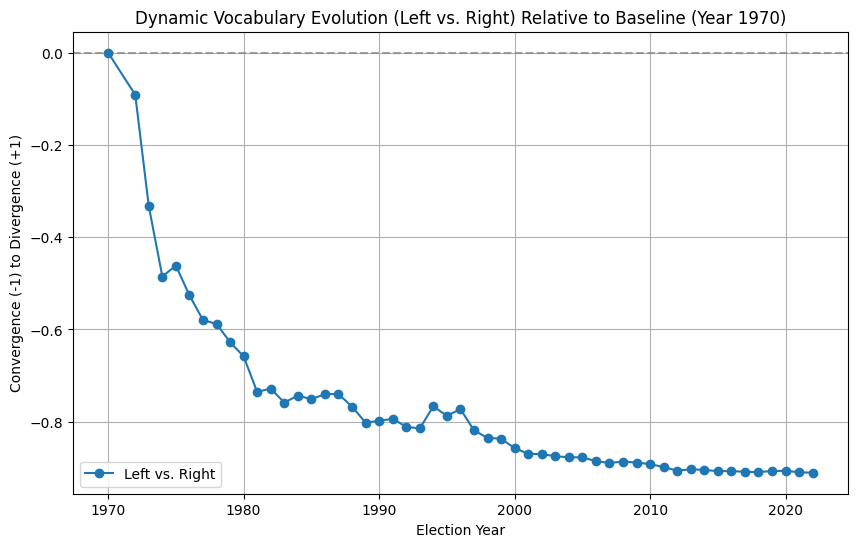

In [59]:
# =============================================================================
# 1) Helper Functions
# =============================================================================

def compute_over_common_words(df, country_col, text_col, threshold_ratio=1.5, min_freq=5):
    """
    For each country, compute words that are "over-common" compared to overall usage.
    Returns a dict {country: set_of_overcommon_words}.
    """
    overall_counts = {}
    total_docs = len(df)
    
    # Compute overall doc frequency
    for text in df[text_col]:
        tokens = set(text.lower().split())
        for token in tokens:
            overall_counts[token] = overall_counts.get(token, 0) + 1
    
    # Only consider words appearing in at least min_freq docs
    overall_prop = {w: c/total_docs for w, c in overall_counts.items() if c >= min_freq}
    
    country_over_common = {}
    for country, group in df.groupby(country_col):
        country_total = len(group)
        country_counts = {}
        for text in group[text_col]:
            tokens = set(text.lower().split())
            for token in tokens:
                if token in overall_prop:
                    country_counts[token] = country_counts.get(token, 0) + 1
        
        overcommon_set = set()
        for token, count in country_counts.items():
            country_prop = count / country_total
            if country_prop / overall_prop[token] > threshold_ratio:
                overcommon_set.add(token)
        country_over_common[country] = overcommon_set
    
    return country_over_common

def remove_country_over_common(text, country, over_common_dict):
    """
    Remove words flagged as over-common for the given country.
    """
    tokens = text.lower().split()
    filtered = [t for t in tokens if t not in over_common_dict.get(country, set())]
    return " ".join(filtered)

def get_vocabulary(text_series):
    """Return the set of unique tokens in a Series of texts."""
    vocab = set()
    for text in text_series:
        vocab.update(text.lower().split())
    return vocab

def transform_similarity(sim, baseline):
    """
    Map cosine similarity 'sim' to [-1, +1], with 'baseline' mapped to 0:
    - sim == baseline => 0
    - sim > baseline => negative (more similar => 'convergence')
    - sim < baseline => positive (less similar => 'divergence')
    """
    if baseline <= 0:
        return 1 - sim  # fallback
    if baseline >= 1:
        return sim - 1  # fallback
    if sim >= baseline:
        return -(sim - baseline) / (1 - baseline)
    else:
        return (baseline - sim) / baseline

# =============================================================================
# 2) Starting Point: df_full with 'lrgen' already predicted
# =============================================================================
# We assume df_full has:
#   - 'text'   (lemmatized text)
#   - 'country'
#   - 'lrgen'
#   - 'election_year'
# and missing 'lrgen' have been filled.

# -----------------------------------------------------------------------------
# A) Remove Over-Common Country-Specific Words
# -----------------------------------------------------------------------------
country_overcommon = compute_over_common_words(
    df_full,
    country_col='country',
    text_col='text',
    threshold_ratio=1.5,
    min_freq=5
)

df_full['text_clean'] = df_full.apply(
    lambda row: remove_country_over_common(row['text'], row['country'], country_overcommon),
    axis=1
)

# -----------------------------------------------------------------------------
# B) Split into Left (lrgen <= 5) and Right (lrgen > 5)
# -----------------------------------------------------------------------------
df_left = df_full[df_full['lrgen'] <= 5].copy()
df_right = df_full[df_full['lrgen'] > 5].copy()

# -----------------------------------------------------------------------------
# C) Define 1970 as Baseline and Starting Year
# -----------------------------------------------------------------------------
t0 = 1970

# Filter out years before 1970
df_left = df_left[df_left['election_year'] >= t0]
df_right = df_right[df_right['election_year'] >= t0]

# Collect the sorted years >= 1970
all_years = sorted(set(df_left['election_year']).union(df_right['election_year']))

if t0 not in all_years:
    raise ValueError(f"Baseline year {t0} not found in dataset (after filtering).")

# -----------------------------------------------------------------------------
# D) Dynamic Overlap Vocabulary + Cosine Similarity (Left vs. Right)
# -----------------------------------------------------------------------------
overlap_vocab = set()  # We'll build this up year by year
similarity_dict = {}

for year in all_years:
    # 1) Gather new docs for this year
    df_left_year = df_left[df_left['election_year'] == year]
    df_right_year = df_right[df_right['election_year'] == year]
    
    # 2) Find new overlapping words for the year
    new_vocab_left = get_vocabulary(df_left_year['text_clean'])
    new_vocab_right = get_vocabulary(df_right_year['text_clean'])
    new_overlap = new_vocab_left.intersection(new_vocab_right)
    
    # 3) Expand the global overlap vocabulary
    overlap_vocab = overlap_vocab.union(new_overlap)
    
    # 4) Build a TF-IDF vectorizer on the combined text from both groups up to this year
    df_cum_left = df_left[df_left['election_year'] <= year]
    df_cum_right = df_right[df_right['election_year'] <= year]
    
    combined_texts = pd.concat([df_cum_left['text_clean'], df_cum_right['text_clean']])
    
    vectorizer_dynamic = TfidfVectorizer(vocabulary=list(overlap_vocab))
    vectorizer_dynamic.fit(combined_texts)
    
    # 5) Compute cumulative centroids
    left_cum_matrix = vectorizer_dynamic.transform(df_cum_left['text_clean'])
    right_cum_matrix = vectorizer_dynamic.transform(df_cum_right['text_clean'])
    
    centroid_left = left_cum_matrix.mean(axis=0).A.flatten()
    centroid_right = right_cum_matrix.mean(axis=0).A.flatten()
    
    # 6) Cosine similarity between Left & Right centroids
    sim = cosine_similarity([centroid_left], [centroid_right])[0][0]
    similarity_dict[year] = sim

# -----------------------------------------------------------------------------
# E) Transform Similarities so that t0 => 0
# -----------------------------------------------------------------------------
baseline = similarity_dict[t0]
transformed_dict = {}
for year in all_years:
    sim_val = similarity_dict[year]
    transformed_dict[year] = transform_similarity(sim_val, baseline)

# -----------------------------------------------------------------------------
# F) Plot the Convergence/Divergence Over Time (1970 => 0 on X-axis)
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.plot(all_years, [transformed_dict[y] for y in all_years], marker='o', label='Left vs. Right')
plt.xlabel('Election Year')
plt.ylabel('Convergence (-1) to Divergence (+1)')
plt.title(f"Dynamic Vocabulary Evolution (Left vs. Right) Relative to Baseline (Year {t0})")
plt.legend()
plt.grid(True)
plt.show()

## b. Applied to `text_lemma`

### (i) First Attempt

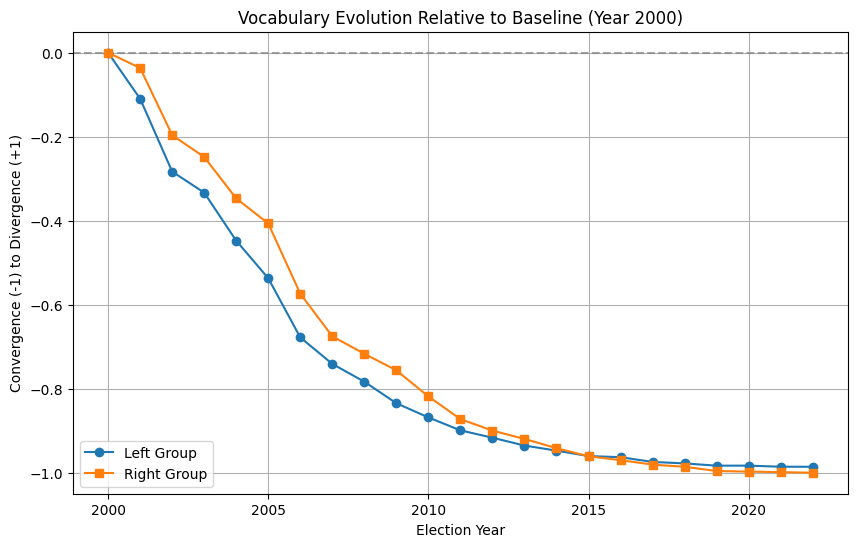

In [60]:
def transform_similarity(sim, baseline):
    """
    Maps cosine similarity 'sim' to a value in [-1, +1],
    using 'baseline' as the pivot that maps to 0.
    
    - If sim == baseline, returns 0.
    - If sim > baseline, returns negative (down to -1).
    - If sim < baseline, returns positive (up to +1).
    """
    # Edge cases: if baseline is 0 or 1, the formula can break.
    # We'll do a safe check:
    if baseline <= 0:
        # No room for negative side
        return 1 - sim  # fallback
    if baseline >= 1:
        # No room for positive side
        return sim - 1  # fallback
    
    if sim >= baseline:
        # More similarity => negative direction
        return -(sim - baseline) / (1 - baseline)
    else:
        # Less similarity => positive direction
        return (baseline - sim) / baseline

# -------------------------------------------------
# 1) Split Data & Get Overlapping Vocabulary
# -------------------------------------------------
df_left = df_full[df_full['lrgen'] <= 5].copy()
df_right = df_full[df_full['lrgen'] > 5].copy()

def get_vocabulary(text_series):
    vocab = set()
    for text in text_series:
        vocab.update(text.lower().split())
    return vocab

vocab_left = get_vocabulary(df_left['text_lemma'])
vocab_right = get_vocabulary(df_right['text_lemma'])
overlap_vocab = vocab_left.intersection(vocab_right)

vectorizer = TfidfVectorizer(vocabulary=list(overlap_vocab))

# Overall centroids for each group
tfidf_left = vectorizer.fit_transform(df_left['text_lemma'])
tfidf_right = vectorizer.fit_transform(df_right['text_lemma'])

centroid_left = tfidf_left.mean(axis=0).A.flatten()   # convert to 1D array
centroid_right = tfidf_right.mean(axis=0).A.flatten()

# -------------------------------------------------
# 2) Define a function to compute cumulative similarity
# -------------------------------------------------
def compute_cumulative_similarity(df_group, vectorizer, overall_centroid):
    """
    Returns a dict: {year: similarity}, 
    measuring how the group's cumulative centroid (up to each year)
    compares to 'overall_centroid'.
    """
    sim_by_year = {}
    for year in sorted(df_group['election_year'].unique()):
        df_cum = df_group[df_group['election_year'] <= year]
        tfidf_cum = vectorizer.transform(df_cum['text_lemma'])
        cum_centroid = tfidf_cum.mean(axis=0).A.flatten()
        sim = cosine_similarity([cum_centroid], [overall_centroid])[0][0]
        sim_by_year[year] = sim
    return sim_by_year

sim_left = compute_cumulative_similarity(df_left, vectorizer, centroid_left)
sim_right = compute_cumulative_similarity(df_right, vectorizer, centroid_right)

# -------------------------------------------------
# 3) Choose year=2000 as the baseline
# -------------------------------------------------
t0 = 2000
baseline_left = sim_left.get(t0, None)
baseline_right = sim_right.get(t0, None)

if baseline_left is None or baseline_right is None:
    raise ValueError("Year 2000 not found in one of the groups. Adjust code or pick another baseline.")

# -------------------------------------------------
# 4) Transform each similarity so that baseline=0
#    and plot from 2000 onward
# -------------------------------------------------
def transform_similarity(sim, baseline):
    if baseline <= 0:
        return 1 - sim  # fallback
    if baseline >= 1:
        return sim - 1  # fallback
    
    if sim >= baseline:
        # More similarity => negative
        return -(sim - baseline) / (1 - baseline)
    else:
        # Less similarity => positive
        return (baseline - sim) / baseline

# Build lists of (year, transformed_value) for each group
years_left = sorted(y for y in sim_left.keys() if y >= t0)
trans_left = [transform_similarity(sim_left[y], baseline_left) for y in years_left]

years_right = sorted(y for y in sim_right.keys() if y >= t0)
trans_right = [transform_similarity(sim_right[y], baseline_right) for y in years_right]

# -------------------------------------------------
# 5) Plot the results
# -------------------------------------------------
plt.figure(figsize=(10,6))
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)  # center line at y=0
plt.plot(years_left, trans_left, marker='o', label='Left Group')
plt.plot(years_right, trans_right, marker='s', label='Right Group')
plt.xlabel('Election Year')
plt.ylabel('Convergence (-1) to Divergence (+1)')
plt.title('Vocabulary Evolution Relative to Baseline (Year 2000)')
plt.legend()
plt.grid(True)
plt.show()

### (ii) Second Attempt

Initial overlapping vocabulary size (t0): 8973


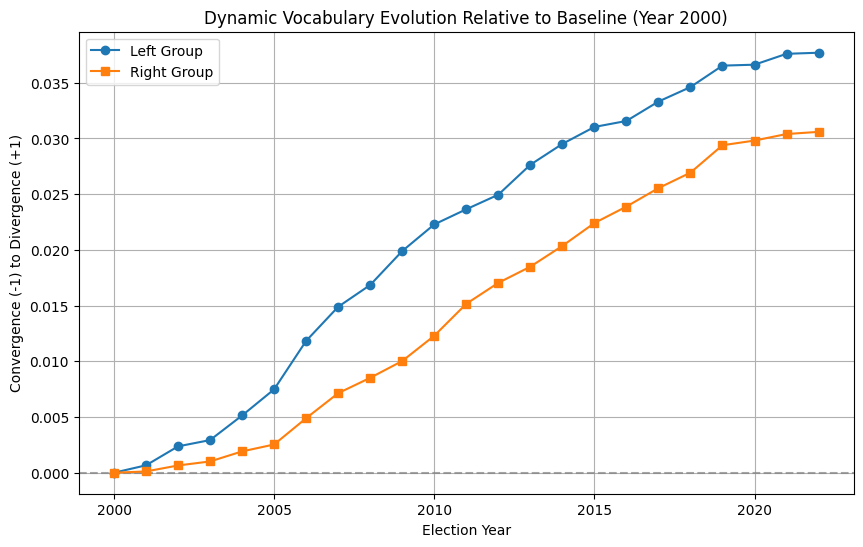

In [61]:
# =============================================================================
# Step 1: Define Helper Functions
# =============================================================================

def compute_over_common_words(df, country_col, text_col, threshold_ratio=1.5, min_freq=5):
    """
    For each country, compute words that are over-represented in that country's documents
    relative to the overall frequency.
    Returns a dictionary mapping each country to its set of over-common words.
    """
    overall_counts = {}
    total_docs = len(df)
    
    # Overall document frequency (unique tokens per document)
    for text in df[text_col]:
        tokens = set(text.lower().split())
        for token in tokens:
            overall_counts[token] = overall_counts.get(token, 0) + 1
    
    overall_prop = {word: count/total_docs for word, count in overall_counts.items() if count >= min_freq}
    
    country_over_common = {}
    for country, group in df.groupby(country_col):
        country_total = len(group)
        country_counts = {}
        for text in group[text_col]:
            tokens = set(text.lower().split())
            for token in tokens:
                if token in overall_prop:
                    country_counts[token] = country_counts.get(token, 0) + 1
        over_common_set = set()
        for token, count in country_counts.items():
            country_prop = count / country_total
            if country_prop / overall_prop[token] > threshold_ratio:
                over_common_set.add(token)
        country_over_common[country] = over_common_set
    return country_over_common

def remove_country_over_common(text, country, over_common_dict):
    """
    Remove words from text that are flagged as over-common for the given country.
    """
    tokens = text.lower().split()
    filtered = [t for t in tokens if t not in over_common_dict.get(country, set())]
    return " ".join(filtered)

def get_vocabulary(text_series):
    """Return the set of unique tokens in a Series of texts."""
    vocab = set()
    for text in text_series:
        vocab.update(text.lower().split())
    return vocab

def transform_similarity(sim, baseline):
    """
    Maps cosine similarity 'sim' to a value in [-1, +1] using 'baseline' as the pivot (mapped to 0).
    - If sim == baseline, returns 0.
    - If sim > baseline (more similar than baseline), returns a negative value (down to -1).
    - If sim < baseline (less similar than baseline), returns a positive value (up to +1).
    """
    if baseline <= 0:
        return 1 - sim  # fallback
    if baseline >= 1:
        return sim - 1  # fallback
    if sim >= baseline:
        return -(sim - baseline) / (1 - baseline)
    else:
        return (baseline - sim) / baseline

def compute_cumulative_similarity(df_group, vectorizer, overall_centroid):
    """
    For each election year in df_group, compute the cumulative centroid (using all docs up to that year)
    and return a dictionary mapping year -> cosine similarity to overall_centroid.
    """
    sim_by_year = {}
    for year in sorted(df_group['election_year'].unique()):
        df_cum = df_group[df_group['election_year'] <= year]
        tfidf_cum = vectorizer.transform(df_cum['text_clean'])
        cum_centroid = tfidf_cum.mean(axis=0).A.flatten()
        sim = cosine_similarity([cum_centroid], [overall_centroid])[0][0]
        sim_by_year[year] = sim
    return sim_by_year

# =============================================================================
# Step 2: Clean the Data – Remove Over-Common Country-Specific Words
# =============================================================================
# (Assuming df_full has columns: 'text_lemma', 'country', 'lrgen', 'election_year')

# Compute over-common words for each country based on the lemmatized text.
country_overcommon = compute_over_common_words(df_full, country_col='country', text_col='text_lemma',
                                               threshold_ratio=1.5, min_freq=5)

# Create a new column 'text_clean' by removing over-common words for each row.
df_full['text_clean'] = df_full.apply(lambda row: remove_country_over_common(row['text_lemma'],
                                                                            row['country'],
                                                                            country_overcommon), axis=1)

# =============================================================================
# Step 3: Split Data into Left and Right Groups Based on lrgen
# =============================================================================
# Left group: lrgen ≤ 5 (including 5), Right group: lrgen > 5.
df_left = df_full[df_full['lrgen'] <= 5].copy()
df_right = df_full[df_full['lrgen'] > 5].copy()

# =============================================================================
# Step 4: Build Initial Overlapping Vocabulary Using Baseline (t0)
# =============================================================================
all_years = sorted(df_full['election_year'].unique())
t0 = 2000  # Choose baseline year (adjust if needed)
if t0 not in all_years:
    raise ValueError(f"Baseline year {t0} not found in dataset.")

# Use all documents up to t0 for both groups.
df_left_t0 = df_left[df_left['election_year'] <= t0]
df_right_t0 = df_right[df_right['election_year'] <= t0]

vocab_left_t0 = get_vocabulary(df_left_t0['text_clean'])
vocab_right_t0 = get_vocabulary(df_right_t0['text_clean'])
overlap_vocab = vocab_left_t0.intersection(vocab_right_t0)
print("Initial overlapping vocabulary size (t0):", len(overlap_vocab))

# =============================================================================
# Step 5: Compute Baseline Centroids Using TF-IDF Restricted to Overlap Vocab
# =============================================================================
vectorizer_t0 = TfidfVectorizer(vocabulary=list(overlap_vocab))

tfidf_left_t0 = vectorizer_t0.fit_transform(df_left_t0['text_clean'])
tfidf_right_t0 = vectorizer_t0.fit_transform(df_right_t0['text_clean'])

centroid_left_t0 = tfidf_left_t0.mean(axis=0).A.flatten()
centroid_right_t0 = tfidf_right_t0.mean(axis=0).A.flatten()

# We'll use these as the overall centroids for the baseline.
overall_left_centroid_t0 = centroid_left_t0
overall_right_centroid_t0 = centroid_right_t0

# =============================================================================
# Step 6: Dynamically Update Overlapping Vocabulary and Compute Cumulative Similarity
# =============================================================================
# We'll update the overlap vocabulary year by year (for years > t0) by adding new overlapping words.
sim_left_dict = {t0: cosine_similarity([centroid_left_t0], [overall_left_centroid_t0])[0][0]}  # should be 1.0
sim_right_dict = {t0: cosine_similarity([centroid_right_t0], [overall_right_centroid_t0])[0][0]}

for year in [y for y in all_years if y > t0]:
    # 5.1) Get new documents for this year from each group.
    df_left_year = df_left[df_left['election_year'] == year]
    df_right_year = df_right[df_right['election_year'] == year]
    
    # 5.2) Find new words from this year.
    new_vocab_left = get_vocabulary(df_left_year['text_clean'])
    new_vocab_right = get_vocabulary(df_right_year['text_clean'])
    new_overlap = new_vocab_left.intersection(new_vocab_right)
    
    # 5.3) Update the global overlapping vocabulary.
    if new_overlap:
        overlap_vocab = overlap_vocab.union(new_overlap)
    
    # 5.4) Build new vectorizers (one for each group) with the updated vocabulary,
    # then fit them on the baseline documents to compute the updated idf values.
    vectorizer_left_dynamic = TfidfVectorizer(vocabulary=list(overlap_vocab))
    vectorizer_left_dynamic.fit(df_left_t0['text_clean'])
    tfidf_left_t0_dynamic = vectorizer_left_dynamic.transform(df_left_t0['text_clean'])
    baseline_left_dynamic = tfidf_left_t0_dynamic.mean(axis=0).A.flatten()
    
    vectorizer_right_dynamic = TfidfVectorizer(vocabulary=list(overlap_vocab))
    vectorizer_right_dynamic.fit(df_right_t0['text_clean'])
    tfidf_right_t0_dynamic = vectorizer_right_dynamic.transform(df_right_t0['text_clean'])
    baseline_right_dynamic = tfidf_right_t0_dynamic.mean(axis=0).A.flatten()
    
    # 5.5) Compute the cumulative centroid for Left group (all docs up to current year)
    df_left_cum = df_left[df_left['election_year'] <= year]
    tfidf_left_cum = vectorizer_left_dynamic.transform(df_left_cum['text_clean'])
    centroid_left_cum = tfidf_left_cum.mean(axis=0).A.flatten()
    sim_left_dict[year] = cosine_similarity([centroid_left_cum], [baseline_left_dynamic])[0][0]
    
    # 5.6) Repeat for Right group.
    df_right_cum = df_right[df_right['election_year'] <= year]
    tfidf_right_cum = vectorizer_right_dynamic.transform(df_right_cum['text_clean'])
    centroid_right_cum = tfidf_right_cum.mean(axis=0).A.flatten()
    sim_right_dict[year] = cosine_similarity([centroid_right_cum], [baseline_right_dynamic])[0][0]

# =============================================================================
# Step 7: Transform Similarities to Center at t0 (Baseline = 0)
# =============================================================================
baseline_left = sim_left_dict[t0]  # should be 1.0
baseline_right = sim_right_dict[t0]  # should be 1.0

# Create lists for plotting: only years from t0 onward.
years_left = sorted([y for y in sim_left_dict.keys() if y >= t0])
years_right = sorted([y for y in sim_right_dict.keys() if y >= t0])

trans_left = [transform_similarity(sim_left_dict[y], baseline_left) for y in years_left]
trans_right = [transform_similarity(sim_right_dict[y], baseline_right) for y in years_right]

# =============================================================================
# Step 8: Plot the Evolution
# =============================================================================
plt.figure(figsize=(10,6))
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)  # center line at y=0
plt.plot(years_left, trans_left, marker='o', label='Left Group')
plt.plot(years_right, trans_right, marker='s', label='Right Group')
plt.xlabel('Election Year')
plt.ylabel('Convergence (-1) to Divergence (+1)')
plt.title('Dynamic Vocabulary Evolution Relative to Baseline (Year {})'.format(t0))
plt.legend()
plt.grid(True)
plt.show()

### (iii) Third Attempt

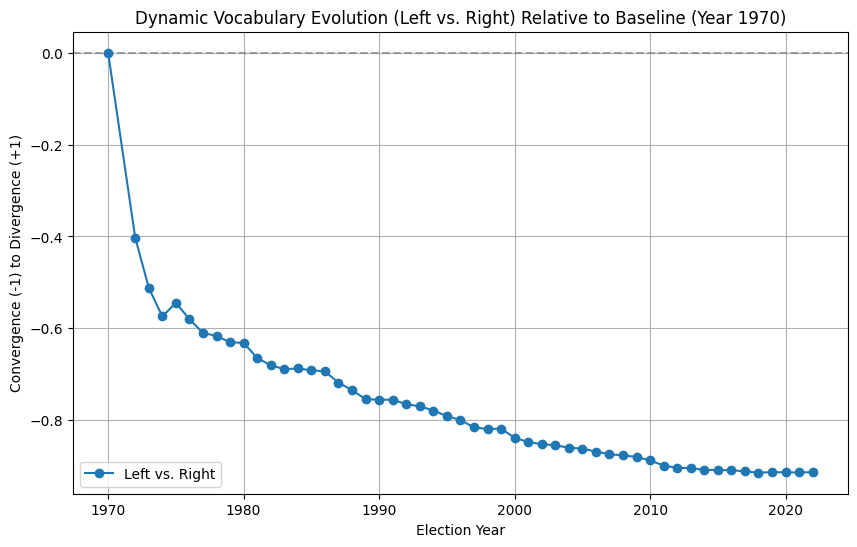

In [63]:
# =============================================================================
# 1) Helper Functions
# =============================================================================

def compute_over_common_words(df, country_col, text_col, threshold_ratio=1.5, min_freq=5):
    """
    For each country, compute words that are "over-common" compared to overall usage.
    Returns a dict {country: set_of_overcommon_words}.
    """
    overall_counts = {}
    total_docs = len(df)
    
    # Compute overall doc frequency
    for text in df[text_col]:
        tokens = set(text.lower().split())
        for token in tokens:
            overall_counts[token] = overall_counts.get(token, 0) + 1
    
    # Only consider words appearing in at least min_freq docs
    overall_prop = {w: c/total_docs for w, c in overall_counts.items() if c >= min_freq}
    
    country_over_common = {}
    for country, group in df.groupby(country_col):
        country_total = len(group)
        country_counts = {}
        for text in group[text_col]:
            tokens = set(text.lower().split())
            for token in tokens:
                if token in overall_prop:
                    country_counts[token] = country_counts.get(token, 0) + 1
        
        overcommon_set = set()
        for token, count in country_counts.items():
            country_prop = count / country_total
            if country_prop / overall_prop[token] > threshold_ratio:
                overcommon_set.add(token)
        country_over_common[country] = overcommon_set
    
    return country_over_common

def remove_country_over_common(text, country, over_common_dict):
    """
    Remove words flagged as over-common for the given country.
    """
    tokens = text.lower().split()
    filtered = [t for t in tokens if t not in over_common_dict.get(country, set())]
    return " ".join(filtered)

def get_vocabulary(text_series):
    """Return the set of unique tokens in a Series of texts."""
    vocab = set()
    for text in text_series:
        vocab.update(text.lower().split())
    return vocab

def transform_similarity(sim, baseline):
    """
    Map cosine similarity 'sim' to [-1, +1], with 'baseline' mapped to 0:
    - sim == baseline => 0
    - sim > baseline => negative (more similar => 'convergence')
    - sim < baseline => positive (less similar => 'divergence')
    """
    if baseline <= 0:
        return 1 - sim  # fallback
    if baseline >= 1:
        return sim - 1  # fallback
    if sim >= baseline:
        return -(sim - baseline) / (1 - baseline)
    else:
        return (baseline - sim) / baseline

# =============================================================================
# 2) Starting Point: df_full with 'lrgen' already predicted
# =============================================================================
# We assume df_full has:
#   - 'text_lemma'   (lemmatized text)
#   - 'country'
#   - 'lrgen'
#   - 'election_year'
# and missing 'lrgen' have been filled.

# -----------------------------------------------------------------------------
# A) Remove Over-Common Country-Specific Words
# -----------------------------------------------------------------------------
country_overcommon = compute_over_common_words(
    df_full,
    country_col='country',
    text_col='text_lemma',
    threshold_ratio=1.5,
    min_freq=5
)

df_full['text_clean'] = df_full.apply(
    lambda row: remove_country_over_common(row['text_lemma'], row['country'], country_overcommon),
    axis=1
)

# -----------------------------------------------------------------------------
# B) Split into Left (lrgen <= 5) and Right (lrgen > 5)
# -----------------------------------------------------------------------------
df_left = df_full[df_full['lrgen'] <= 5].copy()
df_right = df_full[df_full['lrgen'] > 5].copy()

# -----------------------------------------------------------------------------
# C) Define 1970 as Baseline and Starting Year
# -----------------------------------------------------------------------------
t0 = 1970

# Filter out years before 1970
df_left = df_left[df_left['election_year'] >= t0]
df_right = df_right[df_right['election_year'] >= t0]

# Collect the sorted years >= 1970
all_years = sorted(set(df_left['election_year']).union(df_right['election_year']))

if t0 not in all_years:
    raise ValueError(f"Baseline year {t0} not found in dataset (after filtering).")

# -----------------------------------------------------------------------------
# D) Dynamic Overlap Vocabulary + Cosine Similarity (Left vs. Right)
# -----------------------------------------------------------------------------
overlap_vocab = set()  # We'll build this up year by year
similarity_dict = {}

for year in all_years:
    # 1) Gather new docs for this year
    df_left_year = df_left[df_left['election_year'] == year]
    df_right_year = df_right[df_right['election_year'] == year]
    
    # 2) Find new overlapping words for the year
    new_vocab_left = get_vocabulary(df_left_year['text_clean'])
    new_vocab_right = get_vocabulary(df_right_year['text_clean'])
    new_overlap = new_vocab_left.intersection(new_vocab_right)
    
    # 3) Expand the global overlap vocabulary
    overlap_vocab = overlap_vocab.union(new_overlap)
    
    # 4) Build a TF-IDF vectorizer on the combined text from both groups up to this year
    df_cum_left = df_left[df_left['election_year'] <= year]
    df_cum_right = df_right[df_right['election_year'] <= year]
    
    combined_texts = pd.concat([df_cum_left['text_clean'], df_cum_right['text_clean']])
    
    vectorizer_dynamic = TfidfVectorizer(vocabulary=list(overlap_vocab))
    vectorizer_dynamic.fit(combined_texts)
    
    # 5) Compute cumulative centroids
    left_cum_matrix = vectorizer_dynamic.transform(df_cum_left['text_clean'])
    right_cum_matrix = vectorizer_dynamic.transform(df_cum_right['text_clean'])
    
    centroid_left = left_cum_matrix.mean(axis=0).A.flatten()
    centroid_right = right_cum_matrix.mean(axis=0).A.flatten()
    
    # 6) Cosine similarity between Left & Right centroids
    sim = cosine_similarity([centroid_left], [centroid_right])[0][0]
    similarity_dict[year] = sim

# -----------------------------------------------------------------------------
# E) Transform Similarities so that t0 => 0
# -----------------------------------------------------------------------------
baseline = similarity_dict[t0]
transformed_dict = {}
for year in all_years:
    sim_val = similarity_dict[year]
    transformed_dict[year] = transform_similarity(sim_val, baseline)

# -----------------------------------------------------------------------------
# F) Plot the Convergence/Divergence Over Time (1970 => 0 on X-axis)
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.plot(all_years, [transformed_dict[y] for y in all_years], marker='o', label='Left vs. Right')
plt.xlabel('Election Year')
plt.ylabel('Convergence (-1) to Divergence (+1)')
plt.title(f"Dynamic Vocabulary Evolution (Left vs. Right) Relative to Baseline (Year {t0})")
plt.legend()
plt.grid(True)
plt.show()

## c. Applied to `text_no_entities`

### (i) First Attempt

In [ ]:
def transform_similarity(sim, baseline):
    """
    Maps cosine similarity 'sim' to a value in [-1, +1],
    using 'baseline' as the pivot that maps to 0.
    
    - If sim == baseline, returns 0.
    - If sim > baseline, returns negative (down to -1).
    - If sim < baseline, returns positive (up to +1).
    """
    # Edge cases: if baseline is 0 or 1, the formula can break.
    # We'll do a safe check:
    if baseline <= 0:
        # No room for negative side
        return 1 - sim  # fallback
    if baseline >= 1:
        # No room for positive side
        return sim - 1  # fallback
    
    if sim >= baseline:
        # More similarity => negative direction
        return -(sim - baseline) / (1 - baseline)
    else:
        # Less similarity => positive direction
        return (baseline - sim) / baseline

# -------------------------------------------------
# 1) Split Data & Get Overlapping Vocabulary
# -------------------------------------------------
df_left = df_full[df_full['lrgen'] <= 5].copy()
df_right = df_full[df_full['lrgen'] > 5].copy()

def get_vocabulary(text_series):
    vocab = set()
    for text in text_series:
        vocab.update(text.lower().split())
    return vocab

vocab_left = get_vocabulary(df_left['text_no_entities'])
vocab_right = get_vocabulary(df_right['text_no_entities'])
overlap_vocab = vocab_left.intersection(vocab_right)

vectorizer = TfidfVectorizer(vocabulary=list(overlap_vocab))

# Overall centroids for each group
tfidf_left = vectorizer.fit_transform(df_left['text_no_entities'])
tfidf_right = vectorizer.fit_transform(df_right['text_no_entities'])

centroid_left = tfidf_left.mean(axis=0).A.flatten()   # convert to 1D array
centroid_right = tfidf_right.mean(axis=0).A.flatten()

# -------------------------------------------------
# 2) Define a function to compute cumulative similarity
# -------------------------------------------------
def compute_cumulative_similarity(df_group, vectorizer, overall_centroid):
    """
    Returns a dict: {year: similarity}, 
    measuring how the group's cumulative centroid (up to each year)
    compares to 'overall_centroid'.
    """
    sim_by_year = {}
    for year in sorted(df_group['election_year'].unique()):
        df_cum = df_group[df_group['election_year'] <= year]
        tfidf_cum = vectorizer.transform(df_cum['text_no_entities'])
        cum_centroid = tfidf_cum.mean(axis=0).A.flatten()
        sim = cosine_similarity([cum_centroid], [overall_centroid])[0][0]
        sim_by_year[year] = sim
    return sim_by_year

sim_left = compute_cumulative_similarity(df_left, vectorizer, centroid_left)
sim_right = compute_cumulative_similarity(df_right, vectorizer, centroid_right)

# -------------------------------------------------
# 3) Choose year=2000 as the baseline
# -------------------------------------------------
t0 = 2000
baseline_left = sim_left.get(t0, None)
baseline_right = sim_right.get(t0, None)

if baseline_left is None or baseline_right is None:
    raise ValueError("Year 2000 not found in one of the groups. Adjust code or pick another baseline.")

# -------------------------------------------------
# 4) Transform each similarity so that baseline=0
#    and plot from 2000 onward
# -------------------------------------------------
def transform_similarity(sim, baseline):
    if baseline <= 0:
        return 1 - sim  # fallback
    if baseline >= 1:
        return sim - 1  # fallback
    
    if sim >= baseline:
        # More similarity => negative
        return -(sim - baseline) / (1 - baseline)
    else:
        # Less similarity => positive
        return (baseline - sim) / baseline

# Build lists of (year, transformed_value) for each group
years_left = sorted(y for y in sim_left.keys() if y >= t0)
trans_left = [transform_similarity(sim_left[y], baseline_left) for y in years_left]

years_right = sorted(y for y in sim_right.keys() if y >= t0)
trans_right = [transform_similarity(sim_right[y], baseline_right) for y in years_right]

# -------------------------------------------------
# 5) Plot the results
# -------------------------------------------------
plt.figure(figsize=(10,6))
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)  # center line at y=0
plt.plot(years_left, trans_left, marker='o', label='Left Group')
plt.plot(years_right, trans_right, marker='s', label='Right Group')
plt.xlabel('Election Year')
plt.ylabel('Convergence (-1) to Divergence (+1)')
plt.title('Vocabulary Evolution Relative to Baseline (Year 2000)')
plt.legend()
plt.grid(True)
plt.show()

### (ii) Second Attempt

In [ ]:
# =============================================================================
# Step 1: Define Helper Functions
# =============================================================================

def compute_over_common_words(df, country_col, text_col, threshold_ratio=1.5, min_freq=5):
    """
    For each country, compute words that are over-represented in that country's documents
    relative to the overall frequency.
    Returns a dictionary mapping each country to its set of over-common words.
    """
    overall_counts = {}
    total_docs = len(df)
    
    # Overall document frequency (unique tokens per document)
    for text in df[text_col]:
        tokens = set(text.lower().split())
        for token in tokens:
            overall_counts[token] = overall_counts.get(token, 0) + 1
    
    overall_prop = {word: count/total_docs for word, count in overall_counts.items() if count >= min_freq}
    
    country_over_common = {}
    for country, group in df.groupby(country_col):
        country_total = len(group)
        country_counts = {}
        for text in group[text_col]:
            tokens = set(text.lower().split())
            for token in tokens:
                if token in overall_prop:
                    country_counts[token] = country_counts.get(token, 0) + 1
        over_common_set = set()
        for token, count in country_counts.items():
            country_prop = count / country_total
            if country_prop / overall_prop[token] > threshold_ratio:
                over_common_set.add(token)
        country_over_common[country] = over_common_set
    return country_over_common

def remove_country_over_common(text, country, over_common_dict):
    """
    Remove words from text that are flagged as over-common for the given country.
    """
    tokens = text.lower().split()
    filtered = [t for t in tokens if t not in over_common_dict.get(country, set())]
    return " ".join(filtered)

def get_vocabulary(text_series):
    """Return the set of unique tokens in a Series of texts."""
    vocab = set()
    for text in text_series:
        vocab.update(text.lower().split())
    return vocab

def transform_similarity(sim, baseline):
    """
    Maps cosine similarity 'sim' to a value in [-1, +1] using 'baseline' as the pivot (mapped to 0).
    - If sim == baseline, returns 0.
    - If sim > baseline (more similar than baseline), returns a negative value (down to -1).
    - If sim < baseline (less similar than baseline), returns a positive value (up to +1).
    """
    if baseline <= 0:
        return 1 - sim  # fallback
    if baseline >= 1:
        return sim - 1  # fallback
    if sim >= baseline:
        return -(sim - baseline) / (1 - baseline)
    else:
        return (baseline - sim) / baseline

def compute_cumulative_similarity(df_group, vectorizer, overall_centroid):
    """
    For each election year in df_group, compute the cumulative centroid (using all docs up to that year)
    and return a dictionary mapping year -> cosine similarity to overall_centroid.
    """
    sim_by_year = {}
    for year in sorted(df_group['election_year'].unique()):
        df_cum = df_group[df_group['election_year'] <= year]
        tfidf_cum = vectorizer.transform(df_cum['text_clean'])
        cum_centroid = tfidf_cum.mean(axis=0).A.flatten()
        sim = cosine_similarity([cum_centroid], [overall_centroid])[0][0]
        sim_by_year[year] = sim
    return sim_by_year

# =============================================================================
# Step 2: Clean the Data – Remove Over-Common Country-Specific Words
# =============================================================================
# (Assuming df_full has columns: 'text_no_entities', 'country', 'lrgen', 'election_year')

# Compute over-common words for each country based on the lemmatized text.
country_overcommon = compute_over_common_words(df_full, country_col='country', text_col='text_no_entities',
                                               threshold_ratio=1.5, min_freq=5)

# Create a new column 'text_clean' by removing over-common words for each row.
df_full['text_clean'] = df_full.apply(lambda row: remove_country_over_common(row['text_no_entities'],
                                                                            row['country'],
                                                                            country_overcommon), axis=1)

# =============================================================================
# Step 3: Split Data into Left and Right Groups Based on lrgen
# =============================================================================
# Left group: lrgen ≤ 5 (including 5), Right group: lrgen > 5.
df_left = df_full[df_full['lrgen'] <= 5].copy()
df_right = df_full[df_full['lrgen'] > 5].copy()

# =============================================================================
# Step 4: Build Initial Overlapping Vocabulary Using Baseline (t0)
# =============================================================================
all_years = sorted(df_full['election_year'].unique())
t0 = 2000  # Choose baseline year (adjust if needed)
if t0 not in all_years:
    raise ValueError(f"Baseline year {t0} not found in dataset.")

# Use all documents up to t0 for both groups.
df_left_t0 = df_left[df_left['election_year'] <= t0]
df_right_t0 = df_right[df_right['election_year'] <= t0]

vocab_left_t0 = get_vocabulary(df_left_t0['text_clean'])
vocab_right_t0 = get_vocabulary(df_right_t0['text_clean'])
overlap_vocab = vocab_left_t0.intersection(vocab_right_t0)
print("Initial overlapping vocabulary size (t0):", len(overlap_vocab))

# =============================================================================
# Step 5: Compute Baseline Centroids Using TF-IDF Restricted to Overlap Vocab
# =============================================================================
vectorizer_t0 = TfidfVectorizer(vocabulary=list(overlap_vocab))

tfidf_left_t0 = vectorizer_t0.fit_transform(df_left_t0['text_clean'])
tfidf_right_t0 = vectorizer_t0.fit_transform(df_right_t0['text_clean'])

centroid_left_t0 = tfidf_left_t0.mean(axis=0).A.flatten()
centroid_right_t0 = tfidf_right_t0.mean(axis=0).A.flatten()

# We'll use these as the overall centroids for the baseline.
overall_left_centroid_t0 = centroid_left_t0
overall_right_centroid_t0 = centroid_right_t0

# =============================================================================
# Step 6: Dynamically Update Overlapping Vocabulary and Compute Cumulative Similarity
# =============================================================================
# We'll update the overlap vocabulary year by year (for years > t0) by adding new overlapping words.
sim_left_dict = {t0: cosine_similarity([centroid_left_t0], [overall_left_centroid_t0])[0][0]}  # should be 1.0
sim_right_dict = {t0: cosine_similarity([centroid_right_t0], [overall_right_centroid_t0])[0][0]}

for year in [y for y in all_years if y > t0]:
    # 5.1) Get new documents for this year from each group.
    df_left_year = df_left[df_left['election_year'] == year]
    df_right_year = df_right[df_right['election_year'] == year]
    
    # 5.2) Find new words from this year.
    new_vocab_left = get_vocabulary(df_left_year['text_clean'])
    new_vocab_right = get_vocabulary(df_right_year['text_clean'])
    new_overlap = new_vocab_left.intersection(new_vocab_right)
    
    # 5.3) Update the global overlapping vocabulary.
    if new_overlap:
        overlap_vocab = overlap_vocab.union(new_overlap)
    
    # 5.4) Build new vectorizers (one for each group) with the updated vocabulary,
    # then fit them on the baseline documents to compute the updated idf values.
    vectorizer_left_dynamic = TfidfVectorizer(vocabulary=list(overlap_vocab))
    vectorizer_left_dynamic.fit(df_left_t0['text_clean'])
    tfidf_left_t0_dynamic = vectorizer_left_dynamic.transform(df_left_t0['text_clean'])
    baseline_left_dynamic = tfidf_left_t0_dynamic.mean(axis=0).A.flatten()
    
    vectorizer_right_dynamic = TfidfVectorizer(vocabulary=list(overlap_vocab))
    vectorizer_right_dynamic.fit(df_right_t0['text_clean'])
    tfidf_right_t0_dynamic = vectorizer_right_dynamic.transform(df_right_t0['text_clean'])
    baseline_right_dynamic = tfidf_right_t0_dynamic.mean(axis=0).A.flatten()
    
    # 5.5) Compute the cumulative centroid for Left group (all docs up to current year)
    df_left_cum = df_left[df_left['election_year'] <= year]
    tfidf_left_cum = vectorizer_left_dynamic.transform(df_left_cum['text_clean'])
    centroid_left_cum = tfidf_left_cum.mean(axis=0).A.flatten()
    sim_left_dict[year] = cosine_similarity([centroid_left_cum], [baseline_left_dynamic])[0][0]
    
    # 5.6) Repeat for Right group.
    df_right_cum = df_right[df_right['election_year'] <= year]
    tfidf_right_cum = vectorizer_right_dynamic.transform(df_right_cum['text_clean'])
    centroid_right_cum = tfidf_right_cum.mean(axis=0).A.flatten()
    sim_right_dict[year] = cosine_similarity([centroid_right_cum], [baseline_right_dynamic])[0][0]

# =============================================================================
# Step 7: Transform Similarities to Center at t0 (Baseline = 0)
# =============================================================================
baseline_left = sim_left_dict[t0]  # should be 1.0
baseline_right = sim_right_dict[t0]  # should be 1.0

# Create lists for plotting: only years from t0 onward.
years_left = sorted([y for y in sim_left_dict.keys() if y >= t0])
years_right = sorted([y for y in sim_right_dict.keys() if y >= t0])

trans_left = [transform_similarity(sim_left_dict[y], baseline_left) for y in years_left]
trans_right = [transform_similarity(sim_right_dict[y], baseline_right) for y in years_right]

# =============================================================================
# Step 8: Plot the Evolution
# =============================================================================
plt.figure(figsize=(10,6))
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)  # center line at y=0
plt.plot(years_left, trans_left, marker='o', label='Left Group')
plt.plot(years_right, trans_right, marker='s', label='Right Group')
plt.xlabel('Election Year')
plt.ylabel('Convergence (-1) to Divergence (+1)')
plt.title('Dynamic Vocabulary Evolution Relative to Baseline (Year {})'.format(t0))
plt.legend()
plt.grid(True)
plt.show()

### (iii) Third Attempt

In [ ]:
# =============================================================================
# 1) Helper Functions
# =============================================================================

def compute_over_common_words(df, country_col, text_col, threshold_ratio=1.5, min_freq=5):
    """
    For each country, compute words that are "over-common" compared to overall usage.
    Returns a dict {country: set_of_overcommon_words}.
    """
    overall_counts = {}
    total_docs = len(df)
    
    # Compute overall doc frequency
    for text in df[text_col]:
        tokens = set(text.lower().split())
        for token in tokens:
            overall_counts[token] = overall_counts.get(token, 0) + 1
    
    # Only consider words appearing in at least min_freq docs
    overall_prop = {w: c/total_docs for w, c in overall_counts.items() if c >= min_freq}
    
    country_over_common = {}
    for country, group in df.groupby(country_col):
        country_total = len(group)
        country_counts = {}
        for text in group[text_col]:
            tokens = set(text.lower().split())
            for token in tokens:
                if token in overall_prop:
                    country_counts[token] = country_counts.get(token, 0) + 1
        
        overcommon_set = set()
        for token, count in country_counts.items():
            country_prop = count / country_total
            if country_prop / overall_prop[token] > threshold_ratio:
                overcommon_set.add(token)
        country_over_common[country] = overcommon_set
    
    return country_over_common

def remove_country_over_common(text, country, over_common_dict):
    """
    Remove words flagged as over-common for the given country.
    """
    tokens = text.lower().split()
    filtered = [t for t in tokens if t not in over_common_dict.get(country, set())]
    return " ".join(filtered)

def get_vocabulary(text_series):
    """Return the set of unique tokens in a Series of texts."""
    vocab = set()
    for text in text_series:
        vocab.update(text.lower().split())
    return vocab

def transform_similarity(sim, baseline):
    """
    Map cosine similarity 'sim' to [-1, +1], with 'baseline' mapped to 0:
    - sim == baseline => 0
    - sim > baseline => negative (more similar => 'convergence')
    - sim < baseline => positive (less similar => 'divergence')
    """
    if baseline <= 0:
        return 1 - sim  # fallback
    if baseline >= 1:
        return sim - 1  # fallback
    if sim >= baseline:
        return -(sim - baseline) / (1 - baseline)
    else:
        return (baseline - sim) / baseline

# =============================================================================
# 2) Starting Point: df_full with 'lrgen' already predicted
# =============================================================================
# We assume df_full has:
#   - 'text_no_entities'   (lemmatized text)
#   - 'country'
#   - 'lrgen'
#   - 'election_year'
# and missing 'lrgen' have been filled.

# -----------------------------------------------------------------------------
# A) Remove Over-Common Country-Specific Words
# -----------------------------------------------------------------------------
country_overcommon = compute_over_common_words(
    df_full,
    country_col='country',
    text_col='text_no_entities',
    threshold_ratio=1.5,
    min_freq=5
)

df_full['text_clean'] = df_full.apply(
    lambda row: remove_country_over_common(row['text_no_entities'], row['country'], country_overcommon),
    axis=1
)

# -----------------------------------------------------------------------------
# B) Split into Left (lrgen <= 5) and Right (lrgen > 5)
# -----------------------------------------------------------------------------
df_left = df_full[df_full['lrgen'] <= 5].copy()
df_right = df_full[df_full['lrgen'] > 5].copy()

# -----------------------------------------------------------------------------
# C) Define 1970 as Baseline and Starting Year
# -----------------------------------------------------------------------------
t0 = 1970

# Filter out years before 1970
df_left = df_left[df_left['election_year'] >= t0]
df_right = df_right[df_right['election_year'] >= t0]

# Collect the sorted years >= 1970
all_years = sorted(set(df_left['election_year']).union(df_right['election_year']))

if t0 not in all_years:
    raise ValueError(f"Baseline year {t0} not found in dataset (after filtering).")

# -----------------------------------------------------------------------------
# D) Dynamic Overlap Vocabulary + Cosine Similarity (Left vs. Right)
# -----------------------------------------------------------------------------
overlap_vocab = set()  # We'll build this up year by year
similarity_dict = {}

for year in all_years:
    # 1) Gather new docs for this year
    df_left_year = df_left[df_left['election_year'] == year]
    df_right_year = df_right[df_right['election_year'] == year]
    
    # 2) Find new overlapping words for the year
    new_vocab_left = get_vocabulary(df_left_year['text_clean'])
    new_vocab_right = get_vocabulary(df_right_year['text_clean'])
    new_overlap = new_vocab_left.intersection(new_vocab_right)
    
    # 3) Expand the global overlap vocabulary
    overlap_vocab = overlap_vocab.union(new_overlap)
    
    # 4) Build a TF-IDF vectorizer on the combined text from both groups up to this year
    df_cum_left = df_left[df_left['election_year'] <= year]
    df_cum_right = df_right[df_right['election_year'] <= year]
    
    combined_texts = pd.concat([df_cum_left['text_clean'], df_cum_right['text_clean']])
    
    vectorizer_dynamic = TfidfVectorizer(vocabulary=list(overlap_vocab))
    vectorizer_dynamic.fit(combined_texts)
    
    # 5) Compute cumulative centroids
    left_cum_matrix = vectorizer_dynamic.transform(df_cum_left['text_clean'])
    right_cum_matrix = vectorizer_dynamic.transform(df_cum_right['text_clean'])
    
    centroid_left = left_cum_matrix.mean(axis=0).A.flatten()
    centroid_right = right_cum_matrix.mean(axis=0).A.flatten()
    
    # 6) Cosine similarity between Left & Right centroids
    sim = cosine_similarity([centroid_left], [centroid_right])[0][0]
    similarity_dict[year] = sim

# -----------------------------------------------------------------------------
# E) Transform Similarities so that t0 => 0
# -----------------------------------------------------------------------------
baseline = similarity_dict[t0]
transformed_dict = {}
for year in all_years:
    sim_val = similarity_dict[year]
    transformed_dict[year] = transform_similarity(sim_val, baseline)

# -----------------------------------------------------------------------------
# F) Plot the Convergence/Divergence Over Time (1970 => 0 on X-axis)
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.plot(all_years, [transformed_dict[y] for y in all_years], marker='o', label='Left vs. Right')
plt.xlabel('Election Year')
plt.ylabel('Convergence (-1) to Divergence (+1)')
plt.title(f"Dynamic Vocabulary Evolution (Left vs. Right) Relative to Baseline (Year {t0})")
plt.legend()
plt.grid(True)
plt.show()